# PHYS20762 - Project 3

Ellis Huntley<br>
University of Manchester<br>
April 2022

## Project Description

Neutrons, due to their neutral charge, have the ability to penetrate the electron shells of atoms and not be repelled by the Coloumb field, meaning they can pass through materials relativily easily. Understanding the penetration of neutrons through material is crucial in many areas of science, such as nuclear physics, medicine and engineering. 

Limiting the transmission of neutrons is a key safety mechanism within fission reactors. A moderator is used to bring down the energy of fast neutrons to a few $k_{B}T$ i.e. of order of its surroundings, to help sustain the chain reaction. These are known as thermal neutrons. This chain reaction can then be controlled via control rods that help limit or completely stop the chain reaction brought about by radioactive decay. They are typically made of boron, which is particularly good at absorbing neutrons and thus is a natural choice in limiting transmission.

An application that utilises neutron transmission, rather than limit it, is neutron radiography. The penetrating nature of neutrons is used to create images of components engineered for things such as the aerospace or automotive industries. Unlike x-rays, neutrons are sensitive to light elements such as hydrogen or lithium, meaning they are revealing of substances containing that which would otherwise appear invisibile to other methods. These images are used in safety inspections for example, and can help idenitfy cracks, corrosion or internal flaws.

The aim of this project is to develop a simulation of neutrons attempting to penetrate a slab of thickness $T$, considering only thermal neutrons and the processes of absorption and scattering. The simulation will help identify the rates of reflection, absorption and scattering in different materials and determine the characteristic attenuation length for each material by investiagting how the rate of transmission varies with thickness. This will be performed via a Monte Carlo simulation. Monte Carlo methods are, in essence, a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. In physics specifically, Monte Carlo methods are useful for simulating systems with many coupled degrees of freedom, such as fluids, cellular structures, or in this case, disordered materials, where a neutron's interaction with the material is given probabilistically by the Beer-Lambert Law.

In [28]:
#initialisation
import string
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy.constants as pc

%matplotlib notebook



plt.rcParams.update({'font.size': 14})
plt.style.use('default')

In [29]:
#constants
avogadro_number = pc.Avogadro
mass = pc.neutron_mass

water_density = 1 #g/cm^3
water_sigma_a = 0.6652e-24 #cm^2
water_sigma_s = 103e-24 #cm^2
water_molar_mass = 18.02 #g/mol

lead_density = 11.35
lead_sigma_a = 1.58e-25
lead_sigma_s = 1.1221e-23
lead_molar_mass = 207.2

graphite_density = 2.26
graphite_sigma_a = 4.5e-27
graphite_sigma_s = 4.74e-24
graphite_molar_mass = 12.011

boron_density = 2.34
boron_sigma_a = 7.49e-22
boron_sigma_s = 3.1e-24
boron_molar_mass = 10.811


lower_limit = 0 #used when generating random numbers
upper_limit = 1


## Generating Random Numbers

A pseudo-random number generator produces numbers that exhibit statistical randomness. Despite this, the process is entirely deterministic - you generate numbers and, using a starting number, can repeat the entire sequence. This starting number is known as a seed. 

The quintessential example of a pseudo-random generator is the Linear Congreuential Generator (LCG) developed by Derrick Lehmer. It is 

$$X_{n+1} = (aX_{n}+c)\ \text{mod}\   m$$

with the following parameters:

The modulus: $0<m$. 

The multiplier: $0\leq a < m$.

The increment: $0<c<m$. 

The seed: $0\leq X_{0} <m$.

Using these parameters, random numbers can be drawn between 0 and 1 with precision $m$ via 


$$s_{n} = \frac{X_{n}}{m}.$$

LCGs are very widely used but all the points generated via this method lie on hyperplanes, which is not something wanted for this experiment. A demonstration of this is shown below.

<IPython.core.display.Javascript object>


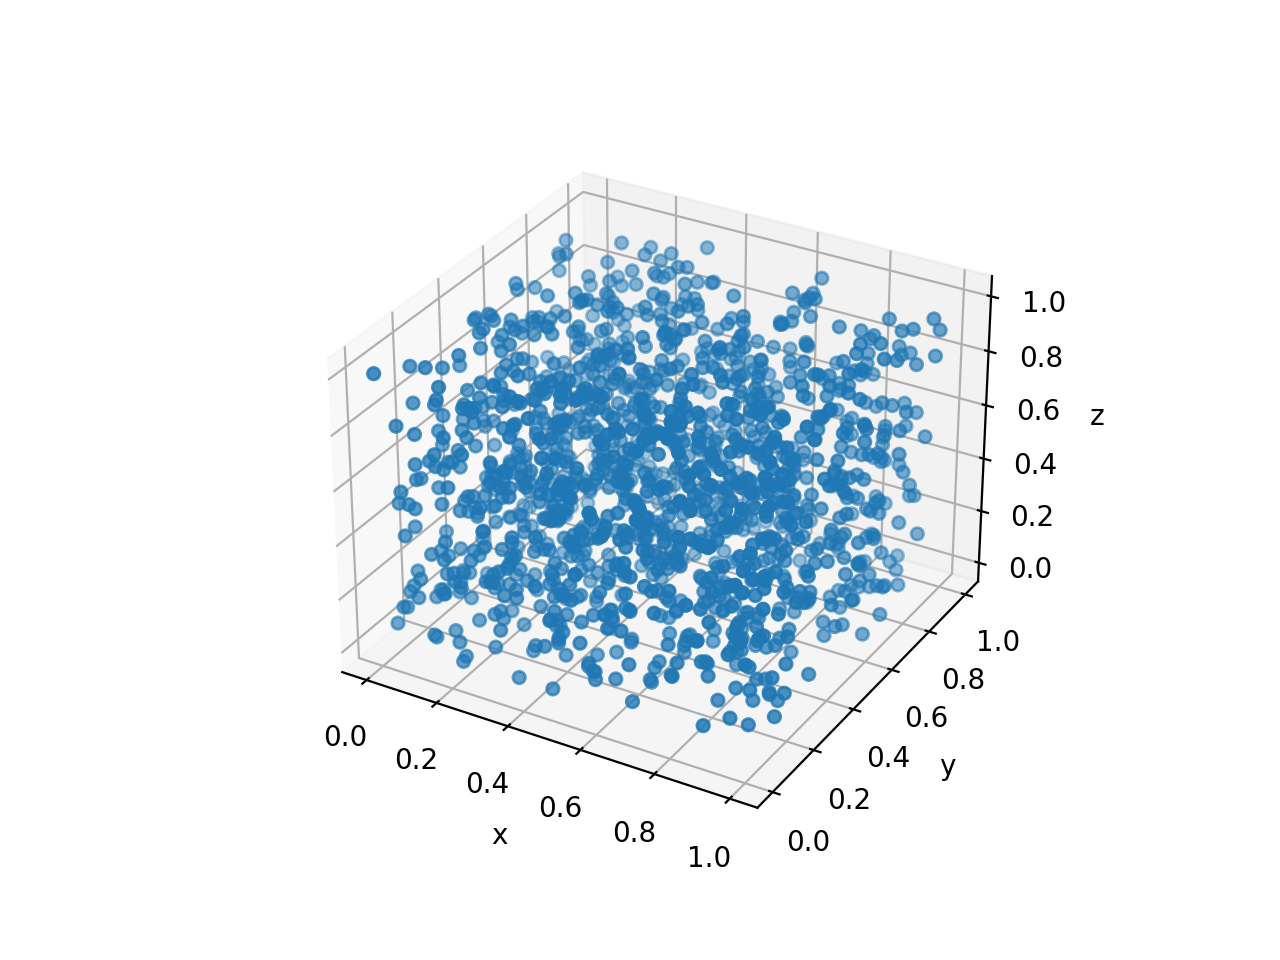

In [30]:
def randssp(p, q):
    
    m = pow(2, 31)
    a = pow(2, 16) + 3
    c = 0
    x = 123456789
    
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            x = np.mod(a*x + c, m)
            r[k, l] = x/m
    
    return r

k = randssp(3, 1500)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(k[0, :], k[1, :], k[2, :])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

Looking at these points that lie on planes is known as the spectral test. It can be seen in the figure above that, when looking at the x-y plane, these points do indeed lie on these planes. Instead, the function np.random.uniform() will be used as it does not suffer from this issue. This function generates random numbers uniformly over a half-open interval. The distribution is given by

$$ p(x) = \frac{1}{a-b}$$

anywhere in the interval $[a, b)$, and is 0 elsewhere. To demonstrate this, values between 0 and 1 will be drawn and shown in a histogram.

True


<IPython.core.display.Javascript object>


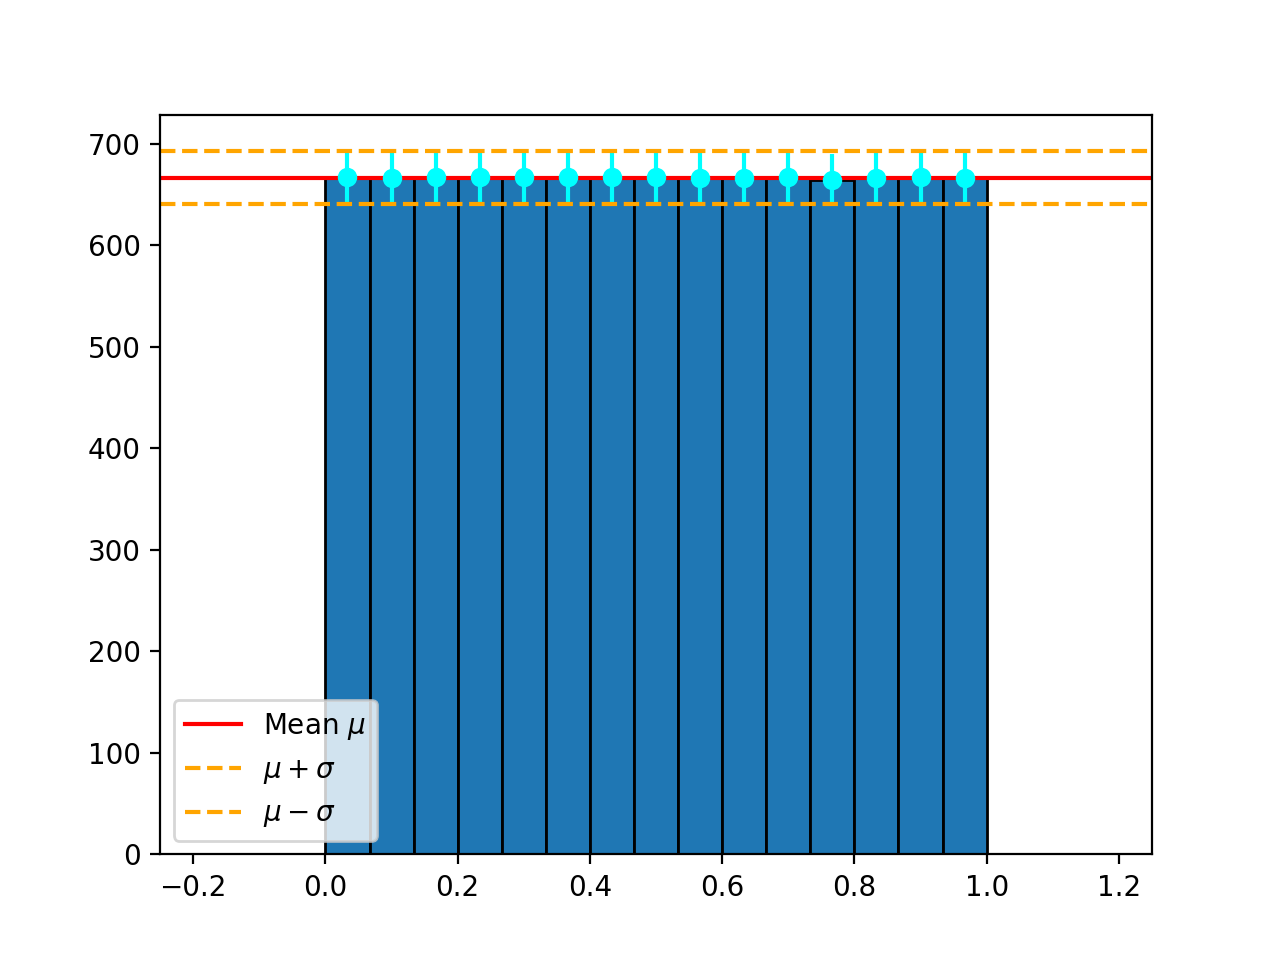

In [31]:
s = np.random.uniform(0, 1, 100)

if np.all(s >= 0) and np.all(s < 1):
    print('True')
else:
    print('False')
    
fig = plt.figure()
ax = fig.add_subplot(111)

histogram = np.empty((1000, 15))

for i in range(1000):
    s = np.random.uniform(0, 1, 10000)
    hist, edges = np.histogram(s, 15)
    histogram[i] = hist

hist_avg = np.mean(histogram, axis=0)
hist_error = np.std(histogram, axis=0)
centers = 0.5*(edges[1:]+ edges[:-1])
mean = (1/15)*10000
error = np.sqrt(mean)


ax.bar(centers, hist_avg, width=1/15, edgecolor='black')
ax.errorbar(centers, hist_avg, yerr=error, fmt='o', c='cyan')
ax.axhline(mean, color='r', label=r'Mean $\mu$')
ax.axhline(mean+error, color='orange', linestyle='--', label=r'$\mu+\sigma$')
ax.axhline(mean-error, color='orange', linestyle='--', label=r'$\mu-\sigma$')
ax.set_xlim(left=-0.25, right=1.25)
ax.legend()
plt.show()

The figure above shows the histogram of the samples, along with the probability density function. It can also be seen that the samples do indeed lie within the half-open interval given by $[0, 1)$. This distribution demonstrates the law of large numbers. It can be seen that mean of each bar on the histogram, given by $\sqrt{np}$  (the sample mean), gets closer, for more iterations, to the population mean, shown by the red line. This is the law of large numbers, which says that
$$\lim_{n \to \infty} \sum_{n=1}^{n} \frac{X_{i}}{n} = \mu $$



It explains how the average of a large sample of independently and identically distributed random variables will be close to their mean. This is the basis for the Monte Carlo simulation. It uses randomness to compute a quantity that may have nothing to do with randomness, but will nevertheless converge to the true value for enough runs.



In [32]:
def random_numbers1D(lower_limit, upper_limit, size):
    """
    Generates a 1d array of random numbers
    
    args:
    lower_limit - float
    upper_limit - float
    size - float
    
    returns:
    arr - array
    """
    
    x = np.random.uniform(lower_limit, upper_limit, size)
    return x



<IPython.core.display.Javascript object>


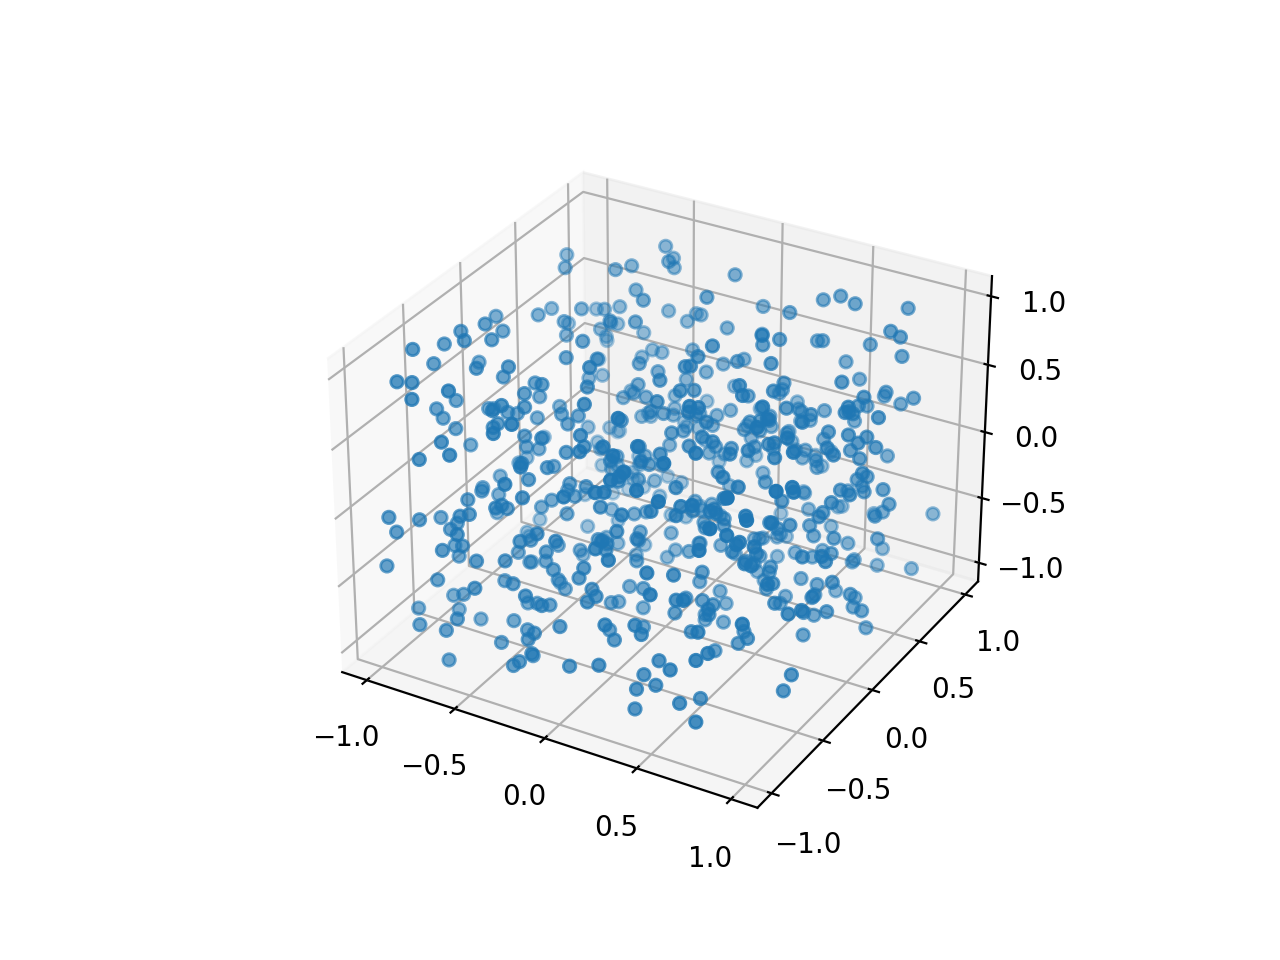

In [33]:
def random_numbers3D(lower_limit, upper_limit, size):
    """
    Generates a 3D array of random points in cartesian coordinates.
    
    args:
    lower_limit - float
    upper_limit - float
    size - float
    
    returns:
    vector - array
    """
    
    x = np.random.uniform(lower_limit, upper_limit, size)
    y = np.random.uniform(lower_limit, upper_limit, size)
    z = np.random.uniform(lower_limit, upper_limit, size)
    
    vector = np.vstack((x,y,z))
    
    return vector

random_cartesian_vector = random_numbers3D(-1, 1, (200,3))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(random_cartesian_vector[:, 0], random_cartesian_vector[:, 1], random_cartesian_vector[:, 2])


It can be seen in the figure above that, when the spectral test is performed, these points do not lie on hyperplanes as they did in the previous method shown, further reinforcing that np.random.uniform is a suitable choice in this simulation.

## Beer-Lambert Law

The probability distribution of a neutron travelling through a material is given by

$$P(x) = \exp(-x/\lambda),$$

a formulation of the Beer-Lambert Law, where $x$ is the distance the neutron has travelled and $\lambda$ is the mean free path (the average distance traveled by a neutron in the target medium between interactions), given by

$$ \lambda = \frac{1}{n(\sigma_{a} + \sigma_{s})}$$

Here $n$ is the number density of the target material, and $\sigma_{a}$ and $\sigma_{s}$ are the microscopic cross sections of absorption and scattering, respectively. A cross secton is simply the probability that a nuclear reaction will occur. For neutrons, the cross section is related to the geometric cross section of the target nucleus. Therefore, cross sections are typically expressed in cm$^{2}$ or barns (b) = $10^{-24}$ cm$^{2}$. A microscopic cross section is the interaction of neutron(s) with a single target nucleus, and a macroscopic cross section is the interaction of neutron(s) with a thick layer of material. 

As seen in the equation above, microscopic cross sections are further broken down into different mechanisms, namely absorption and scattering, the two mechanims considered in this simulation. Scattering is an interaction between a neutron and matter which results in a change in velocity of the neutron. Absorption is a nuclear reaction in which a neutron and target nucleus collide and merge, forming a heavier nucleus (compound nucleus). Depending on factors, including the energy of the incident neutron and the nuclear properties of the target nucleus, the absorption may be followed by the emission of gamma radiation or result in the fission of the compound nucleus.

The cross section values used in this simulation are:


$$\sigma_{a}^{water} = 0.6652 \times 10^{-24} cm^{2}   \ \ \ \ \ \ \ \sigma_{s}^{water} = 103 \times 10^{-24}  cm^{2}$$

$$\sigma_{a}^{lead} = 1.58 \times 10^{-25} cm^{2}   \ \ \ \ \ \ \ \sigma_{s}^{lead} = 1.1221 \times 10^{-23}  cm^{2}$$

$$\sigma_{a}^{graphite} = 4.5 \times 10^{-27} cm^{2}   \ \ \ \ \ \ \ \sigma_{s}^{graphite} = 4.74 \times 10^{-24}  cm^{2}$$

$$\sigma_{a}^{boron} = 7.49 \times 10^{-22} cm^{2}   \ \ \ \ \ \ \ \sigma_{s}^{boron} = 3.1 \times 10^{-24}  cm^{2}$$

which gives the mean free path of each material to be

$$\lambda_{water} = 0.288 \  cm   \ \ \ \ \ \ \ \lambda_{graphite} = 1.86 \ cm$$

$$\lambda_{lead} = 2.66 \ cm   \ \ \ \ \ \ \ \lambda_{boron} = 0.0102 \ cm$$


To sample a random number, $s_{i}$, according to this distribution, the inverse of the equation must be found. This is given by

$$s_{i} = -\lambda\ln(u_{i})$$

where $u_{i}$ is some uniformly distributed random number.



In [34]:
def random_exponential(lower_limit, upper_limit, size, density, mass, sigma_a, sigma_s):
    """
    Creates a exponential distrivtuion using randomly generated numbers.
    
    args:
    lower_limit - float
    upper_limit - float
    size - tuple
    density - float
    mass - float
    sigma_a - float
    sigma_s - float
    
    returns:
    exponential - array
    
    """
    
    number_density = (density/mass) * avogadro_number
    mean_free_path = 1 / (number_density *(sigma_a + sigma_s))
    
    x = random_numbers1D(lower_limit, upper_limit, size)
    exp = -mean_free_path*np.log(x)
    
    return exp, x

## Attenuation In Water Without Scattering

In this section the characteristic attenuation length of water, in the absence of scattering, will be calculated. This will be performed via a first order least squares method on the logarithm of the exponentially distributed numbers. 

Using the previously stated equation

$$ \lambda = \frac{1}{n(\sigma_{a} + \sigma_{s})}$$

and setting $\sigma_{s} = 0$, we can see that the mean free path will equal 45 cm. When scattering is not considered, the mean free path is equal to the characteristic attenuation length, so it also expected that this is equal to 45 cm.


The characteristic attenuation length of absorbed neutrons in water is 44.991 +- 0.011 cm


<IPython.core.display.Javascript object>


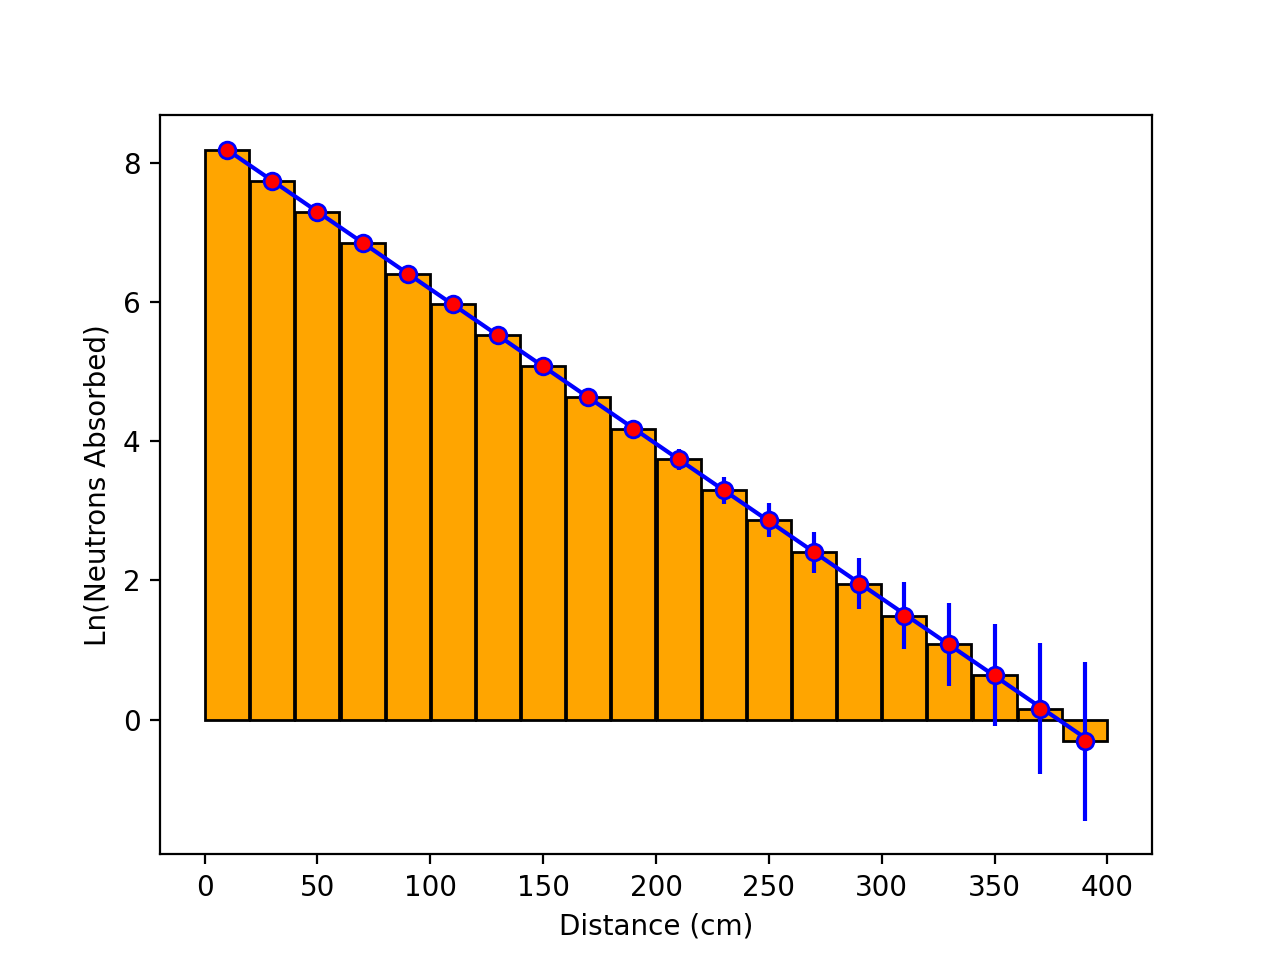

Text(0, 0.5, 'Ln(Neutrons Absorbed)')

In [35]:
number_of_runs = 1000
neutrons_per_run = 10000

def straight_line(m, x, c):
    """
    Creates a straight line using given x values, gradient and y-intercept
    
    args: 
    m - float
    x - array
    c - float
    
    returns:
    y - array
    
    """
   
    y = m*x + c
    return y


def histogram_calculator(count):
    """Computes the histogram of the data set
    
    args:
    count - array
    
    returns:
    hist - array
    edges - array
    
    """
    
     
    x = np.arange(0,401,20) #array that fixes bin sizes
   
    hist, edges = np.histogram(count, bins=x)
    

    
    return hist, edges
    

    

def histogram_average(count):
    
    iterations = 1000 #iterate through number generation/histogram 10 times to take averages
    histograms_array = []
    
    for i in range(iterations):
    
        hist, edges = histogram_calculator(count[i])
        histograms_array.append(hist)
    
        
    error = np.std(histograms_array, axis=0)
    avg_hist = np.mean(histograms_array, axis=0)
    centers = 0.5*(edges[1:]+ edges[:-1])
    
    ln_hist = np.log(avg_hist)
    ln_hist_error = error / avg_hist
    
    return ln_hist, ln_hist_error, centers



def linear_fit(ln_hist, centres, ln_hist_errors):
    """
    Performs a least squares fit of order 1 on the given data.
    
    args:
    ln_hist - array
    centres - array
    ln_hist_errors - array
    
    returns:
    coefficients - array
    
    """
    
    coefficients, errors = np.polyfit(centres, ln_hist, 1, cov=True, w=ln_hist/ln_hist_errors)
    
    mean_path = -1 / coefficients[0]  
    
    coefficient_error = np.sqrt(errors[0][0])
    
    mean_path_error = np.abs(coefficient_error/coefficients[0] * mean_path)
    
    return coefficients, mean_path, mean_path_error


rndm_exp = [random_exponential(0, 1, neutrons_per_run, water_density, water_molar_mass, water_sigma_a, 0)[0] for i in range(number_of_runs)] #water_sigma_s = 0 when scattering is not considered

ln_hist, ln_hist_error, centres = histogram_average(rndm_exp) 

cutoff_index = int(len(centres) * 0.75) #removes the last few bins - their large uncertainties may cause an error when fitting


coefficients, mean_path, mean_path_error = linear_fit(ln_hist[:cutoff_index], centres[:cutoff_index], ln_hist_error[:cutoff_index])

print('The characteristic attenuation length of absorbed neutrons in water is {0:2.3f} +- {1:.3f} cm'.format(mean_path, mean_path_error))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(centres, ln_hist, yerr=ln_hist_error, mfc='red', fmt='o', zorder=2, color='b')
ax.bar(centres, ln_hist, width=np.max(centres)/20, zorder=0, color='orange', edgecolor='black')
    
x_values = np.linspace(np.min(centres), np.max(centres), 500)
y_values = straight_line(coefficients[0], x_values, coefficients[1])

ax.errorbar(x_values, y_values, color='b', zorder=1)
ax.set_xlabel('Distance (cm)')
ax.set_ylabel('Ln(Neutrons Absorbed)')

The figure above shows the histogram of the natural logarithm of the binned neutrons counts, with the straight line fit plotted on top. The gradient of this line is equal to $-1/\lambda$. This process has been ran multiple times for many neutrons so that an average and error can be calculated. It can be seen that the error bars get larger at a greater distance. This is because the probability of a neutron reaching these large distances is very low (decreases exponentially according to the previously stated equation) and so the number of neutrons in these bins varies signficantly from one run to the next. 

We can see this that in this case, when scattering is not considered so the mean free path and characteristic attenuation length are the same quantity, that both values yield 45 cm.

## Isotropic Unit Vectors

The function below generates random points that are distributed on the surface of a unit sphere. These will later will be used to give a direction to some random step taken by a neutron in a material.

<IPython.core.display.Javascript object>


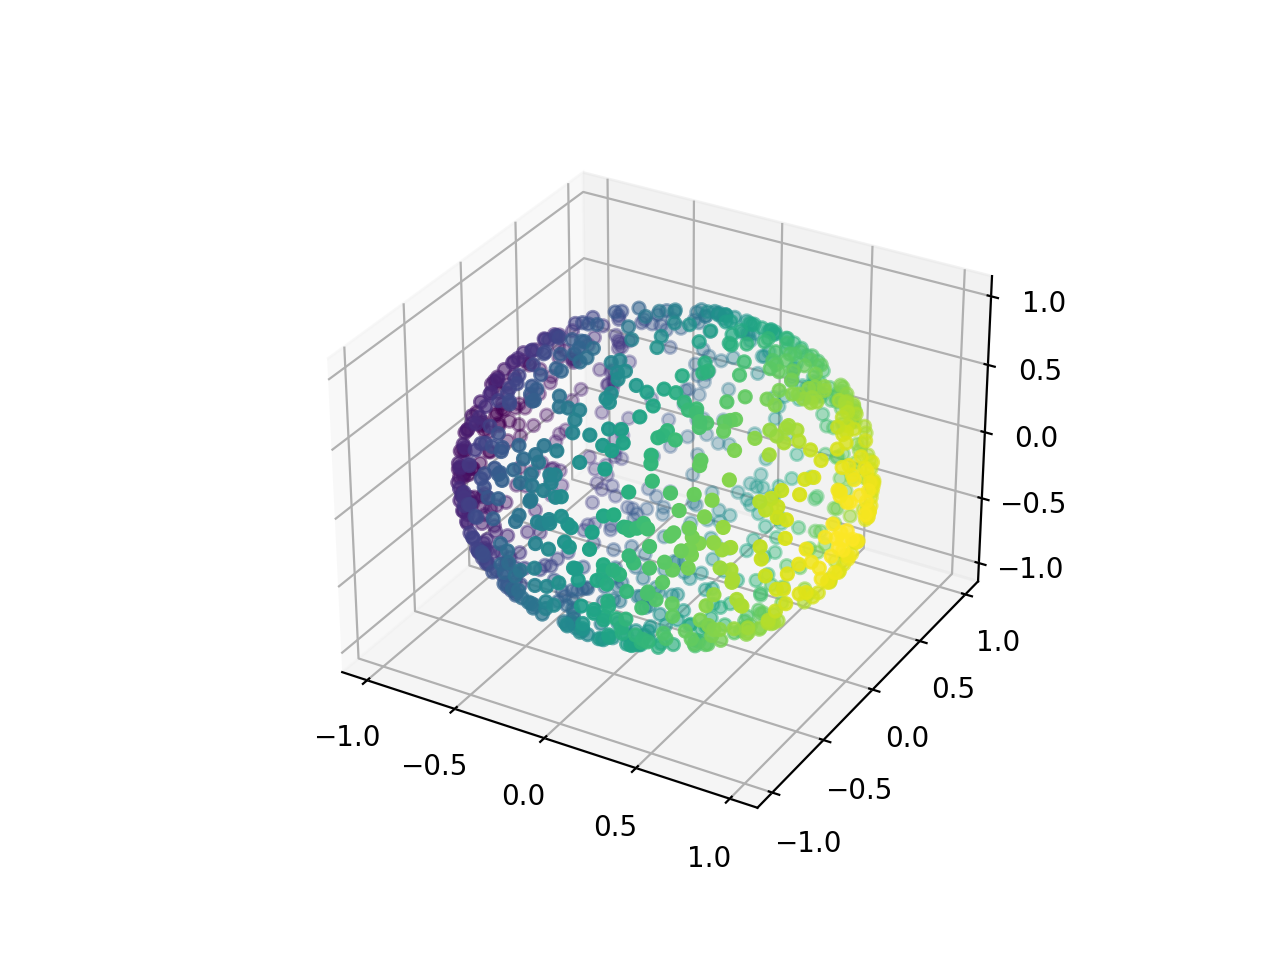

In [36]:
def random_vector(size):
    """
    Generates a random 3D vector with a uniform spherical distribution.
    
    args:
    
    """
    phi = np.random.uniform(0, np.pi*2, size)
    costheta = np.random.uniform(-1, 1, size)
    
    theta = np.arccos(costheta)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    
    return x, y, z

x, y, z = random_vector(1000)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(x, y, z, c=x)



Again, these points do not suffer from the hyperplane problem. It is also worth noting that these points do not buldge in any one place on the surface of the sphere, and are in fact distributed randomly across it.

## Random Exponential Vectors

Using the points distributed on the unit sphere surface, we can select a random direction for a point in space. When this is mutiplied by some random exponentially distributed number, we get the length of the step. This will later be applied to the path of a fired neutron. The cross section values of water will be used here, as an example.

<IPython.core.display.Javascript object>


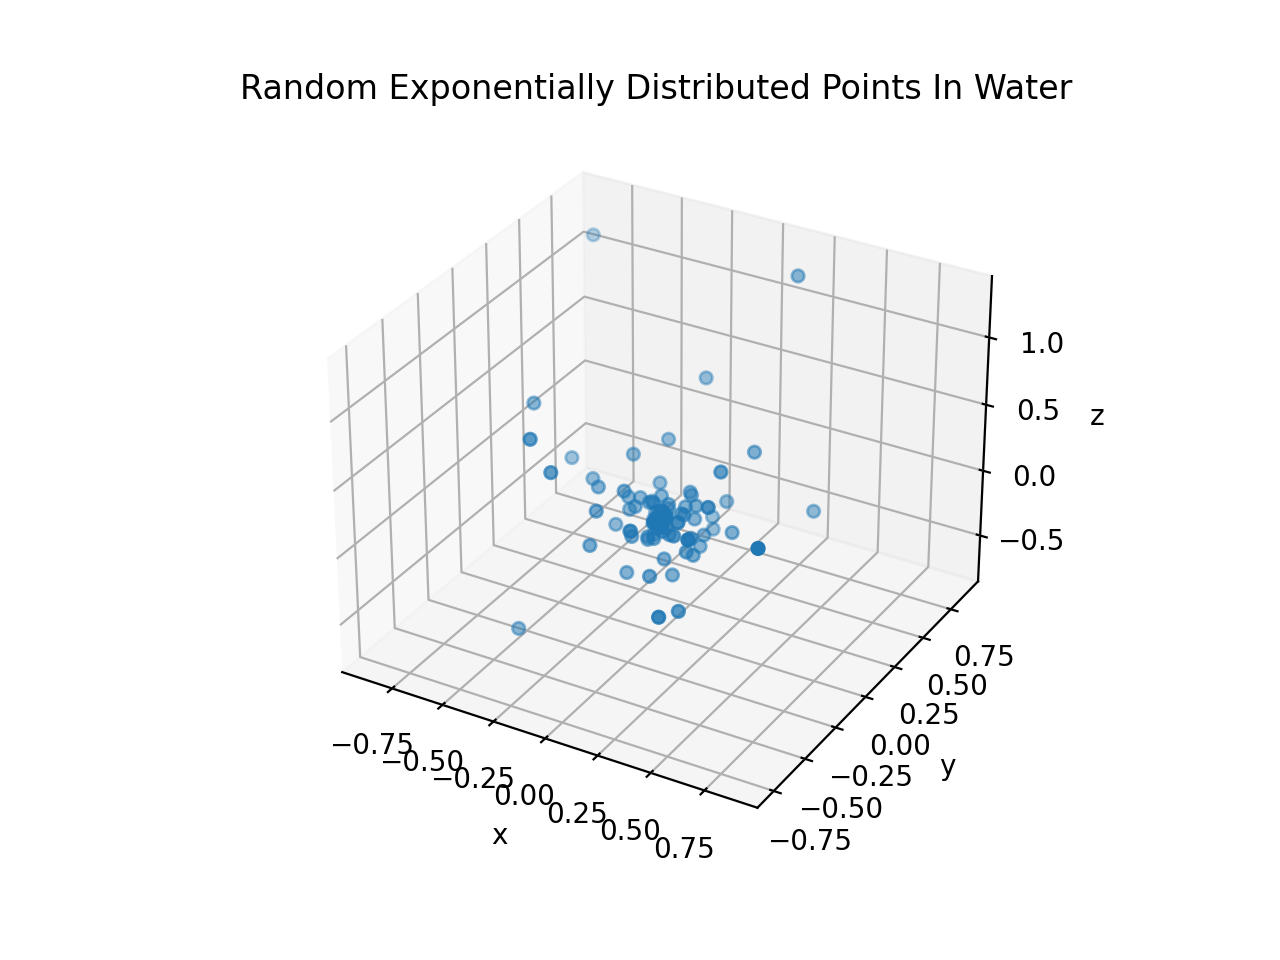

Text(0.5, 0, 'z')

In [37]:
def random_exponential_vector_generator(lower_limit, upper_limit, size, density, mass, sigma_a, sigma_s):
    """
    Generates random numbers to be used as x,y,z components in 3D
    
    args:
    lower_limit - float
    upper_limit - float
    size - array
    density - float
    mass - float
    sigma_a - float
    sigma_s = float
    
    returns:
    random_exp_vector - array
    
    
    """

    vector = np.hstack([random_vector(size)[0], random_vector(size)[1], random_vector(size)[2]])
    random_exp_vector = random_exponential(lower_limit, upper_limit, size, density, mass, sigma_a, sigma_s)[0] * vector

    return random_exp_vector

def random_points(steps, density, mass, sigma_a, sigma_s):
    """
    Generates random points for a given number of steps.
    
    args:
    steps - int
    density - float
    mass - float
    sigma_a - float
    sigma_s - float
    
    returns:
    step - array
    """


    step = np.empty((steps, 3))
    
    
    for i in range(steps):
    
        vec = random_exponential_vector_generator(0, 1, 1, density, mass, sigma_a, sigma_s)
    
        step[i] = vec
        
    return step

points = 100

points = random_points(points, water_density, water_molar_mass, water_sigma_a, water_sigma_s)

fig1 = plt.figure()
ax = fig1.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_title('Random Exponentially Distributed Points In Water')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

Because the distances of the points from the origin are distributed exponentially, it can be seen that most of these points reside very close to the origin. As the distance from the origin increases, less points will be found.

## Random Walk Without Scattering or Absorption

Using the random exponentially generated points to create vectors, we can demonstrate the path of a neutron through water. This walk will terminate after a given number of steps and no scattering or absorption is considered in this section.

<IPython.core.display.Javascript object>


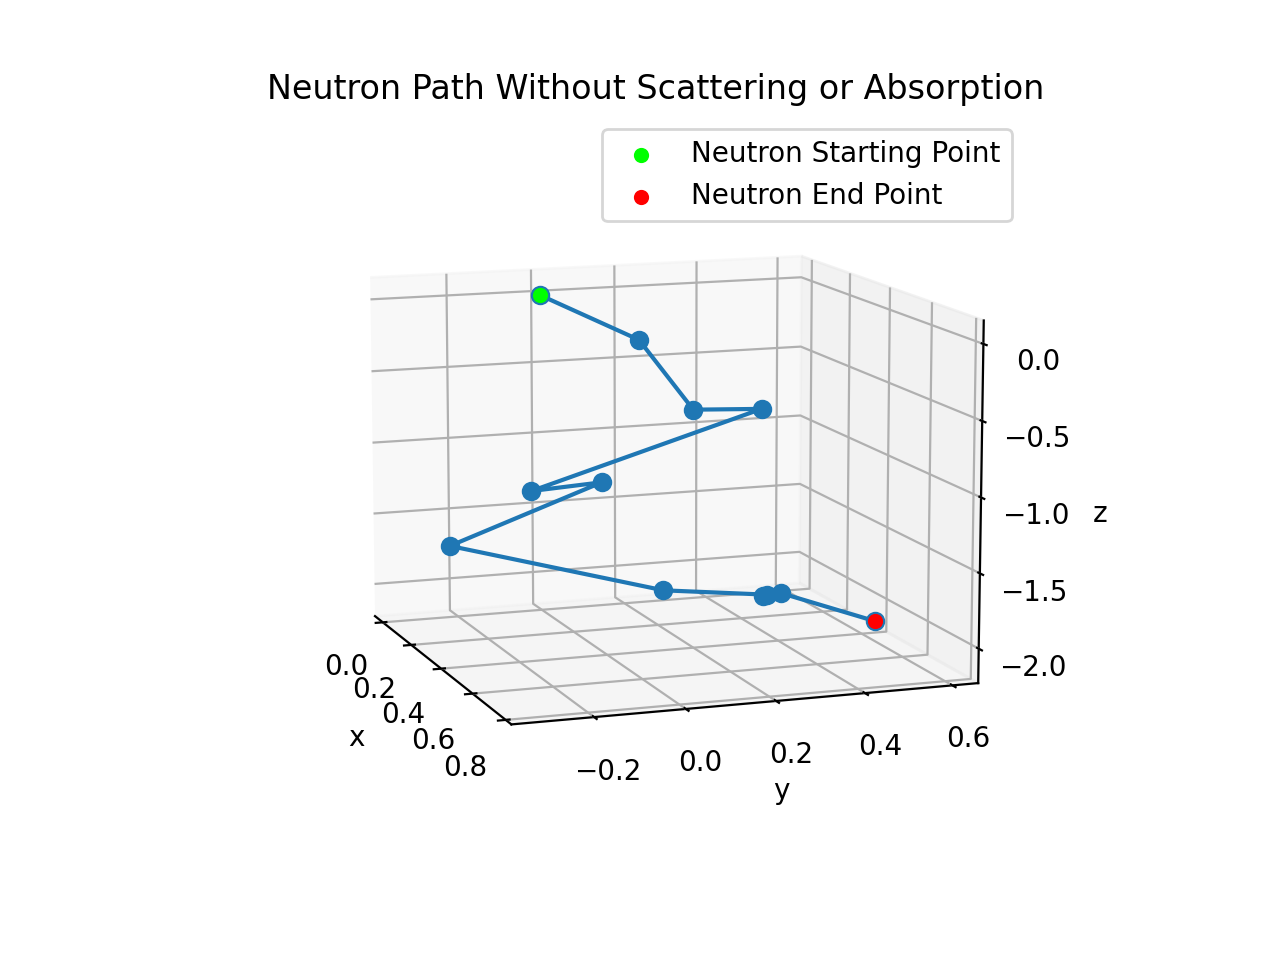

In [44]:
steps = 10


def random_steps(steps, density, mass, sigma_a, sigma_s):
    """
    Produces a given number of random steps, starting at the origin and then moving in x-direction only.
    
    args:
    steps - int
    density - float
    sigma_a - float
    sigma_s - float
    
    returns:
    random_step - array
    """
    
    first_step = random_exponential(lower_limit, upper_limit, 1, density, mass, sigma_a, sigma_s)[0][0]
    first_vector = np.array([first_step, 0, 0]) #uses the first step as the x component of a 3D vector
    random_vectors = random_points(steps, density, mass, sigma_a, sigma_s)
    
    
    random_vectors = np.vstack((np.array([0, 0, 0]), first_vector, random_vectors)) #ensures the neutron starts at the origin, then stacks the other vectors
    steps = np.cumsum(random_vectors, axis=0)

    return steps

water_random_steps = random_steps(steps, water_density, water_molar_mass, water_sigma_a, water_sigma_s)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(0, 0, 0, color='lime', label='Neutron Starting Point')
ax.plot(water_random_steps[:, 0], water_random_steps[:, 1], water_random_steps[:, 2], '-o')
ax.scatter(water_random_steps[-1, 0], water_random_steps[-1, 1], water_random_steps[-1, 2], color='r', label='Neutron End Point')
ax.set_title('Neutron Path Without Scattering or Absorption')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()



## Random Walk In Water

This section demonstrates the path of a neutron in a slab of water of thickness 1cm. The mechanisms (absorption, scattering, reflection) will now be considered. The probability of a neutron being absorbed or scattered is given by

$$ P_{a} = \frac{\sigma_{a}}{\sigma_{a} + \sigma_{s}} \ \ \ P_{s} = \frac{\sigma_{s}}{\sigma_{a} + \sigma_{s}}$$

respectively. As expected, the sum of these probabilites is equal to 1.

The thickness of 1 cm was chosen here as it most easily shows the path of the neutron - nothing is being investigated in this section, it is just a demonstration. If the thickness was say, 10 cm, the neutron could take many steps before its outcome is determined, and this can sometimes appear cumbersome on a plot.

The point (0,0,0) is where the neutron walk will start. The positive x direction has been defined to be the direction into the slab and the negative x direction is the direction of reflection. This model assumes the height and width of the slab is much greater than the thickness, so only the x coordinate must be considered.

The neutron has transmitted through the water after 8 steps.


<IPython.core.display.Javascript object>


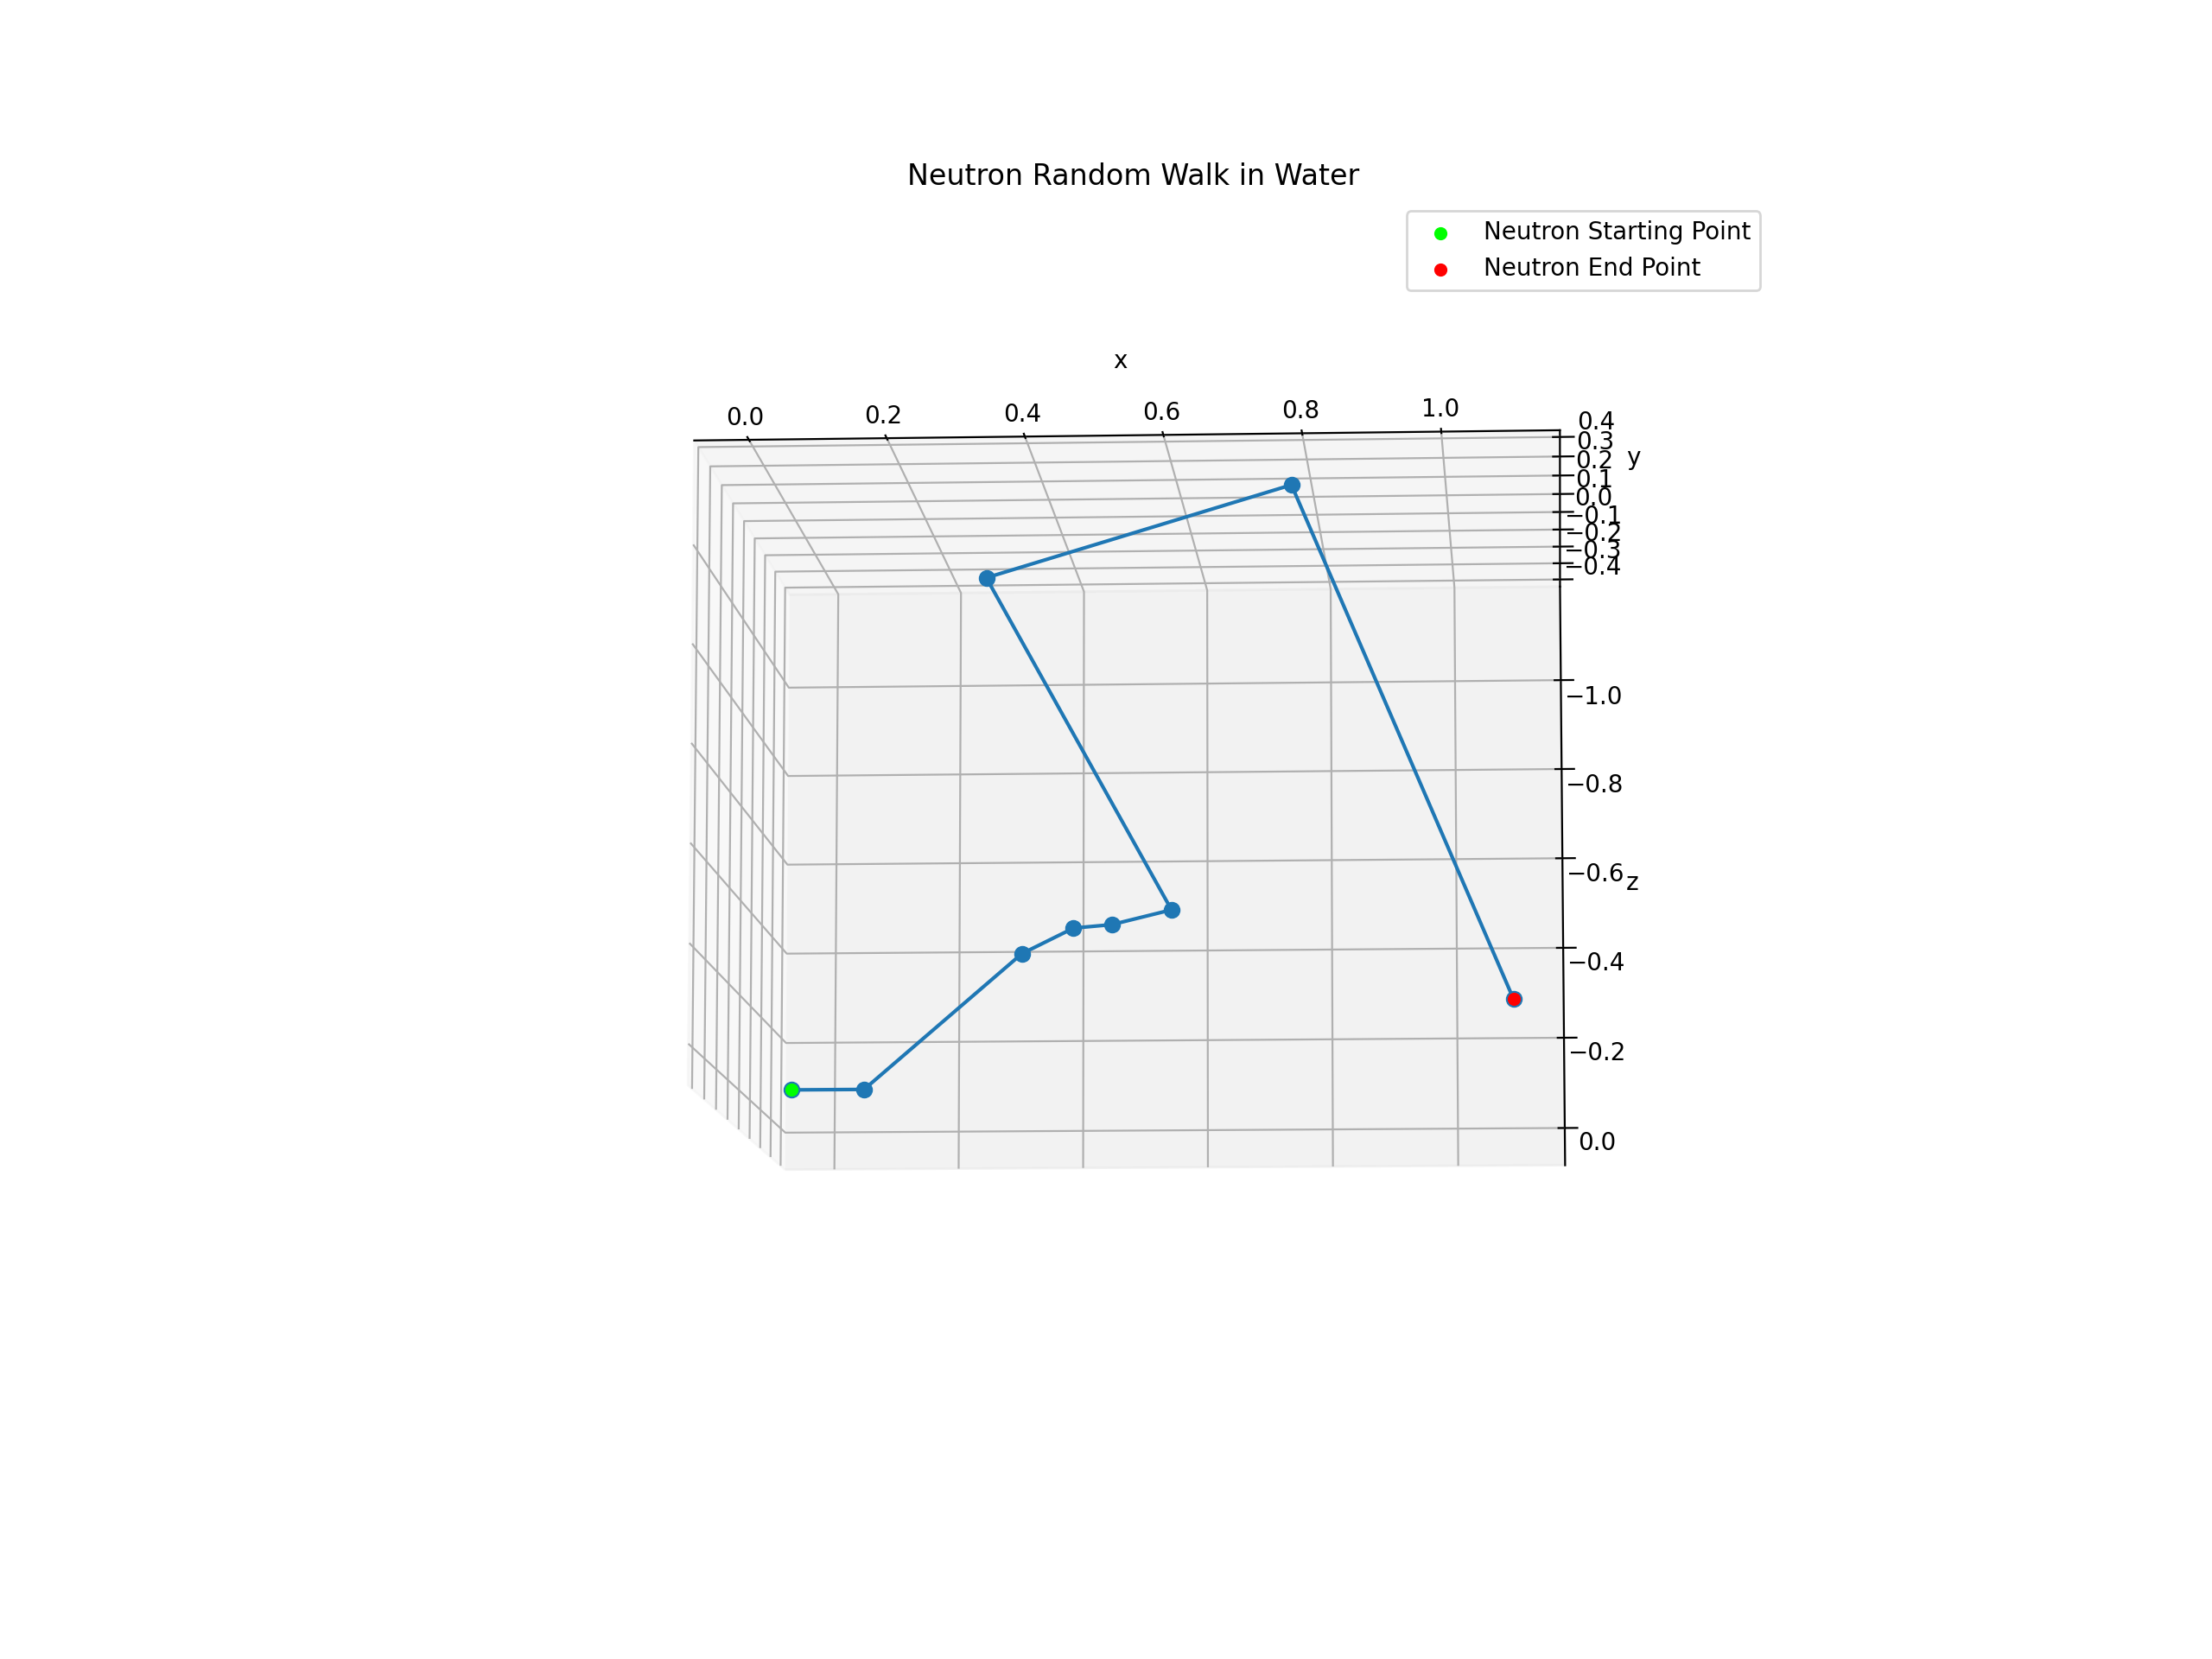

In [52]:
def walk_with_history(sigma_a, sigma_s, density, mass, thickness):
    """
    Produces a random walk for a neutron until the conditions are met. Stores each position so can later be plotted
    
    args:
    sigma_a - float
    sigma_s - float
    density - float
    mass - float
    thickness - float
    
    returns:
    vector - array
    mechanism_counter - array
    step_counter - int
    """
    absorption_probability = sigma_a / (sigma_a + sigma_s)
    scattering_probability = sigma_s / (sigma_a + sigma_s)
    
    vector = random_steps(1, density, mass, sigma_a, sigma_s)
    
    
    step_counter = len(vector)-1 #gives the number of steps taken by the neutron
    
    reflected_counter = 0
    absorbed_counter = 0
    transmitted_counter = 0
    
    if vector[-1, 0] > thickness:
        transmitted_counter += 1
        
    
    while vector[-1, 0] < thickness:
        
        if vector[-1, 0] < 0: #neutron is reflected
            reflected_counter += 1
            break
        
        elif vector[-1, 0] > thickness: #neutron passes through material
            passed_counter += 1
            break
        
        step_counter += 1
        
        new_vector = random_exponential_vector_generator(lower_limit, upper_limit, 1, density, mass, sigma_a, sigma_s)
        new_vector = vector[-1, :] + new_vector
        
        vector = np.vstack((vector, new_vector))
        
        probability = random_numbers1D(lower_limit, upper_limit, 1)[0]
        
        if probability <= absorption_probability: #neutron is absorbed
            absorbed_counter += 1
            break
        
        else: #neutron is scattered
            if vector[-1, 0]>thickness:
                transmitted_counter += 1
                break
            else:
                continue
            
            
    mechanism_counter = np.hstack((reflected_counter, absorbed_counter, transmitted_counter))   
    
    
    
    
    return vector, mechanism_counter, step_counter
    


neutron_walk_history, mechanism_counter, step_counter = walk_with_history(water_sigma_a, water_sigma_s, water_density, water_molar_mass, 1)

if mechanism_counter[0] == 1:
    print('The neutron has been reflected out of the water after {} steps.'.format(step_counter))
elif mechanism_counter[1] == 1:
    print('The neutron has been absorbed by the water after {} steps.'.format(step_counter))
else:
    print('The neutron has transmitted through the water after {} steps.'.format(step_counter))
 
    
fig1 = plt.figure()
ax = fig1.add_subplot(111, projection='3d')
ax.scatter(0, 0, 0, color='lime', label='Neutron Starting Point')
ax.plot(neutron_walk_history[:, 0], neutron_walk_history[:, 1], neutron_walk_history[:, 2], '-o')
ax.scatter(neutron_walk_history[-1, 0], neutron_walk_history[-1, 1], neutron_walk_history[-1, 2], color='r', label='Neutron End Point')
ax.set_title('Neutron Random Walk in Water')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()

 

## Mechanism Rates In 10 cm Material

In this section, the rate of each mechanism will be determined for a slab of thickness 10 cm. The walks of each of the neutrons will be computed, and then repeated several times so an average and error can be calculated. In this case, the previously used function that was necessary to display the path of one neutron is too computationally expensive for this many neutrons. It is only neccessary to store the x component of the neutrons' position, the rest are discarded. A slightly different function will be used here instead.

<IPython.core.display.Javascript object>


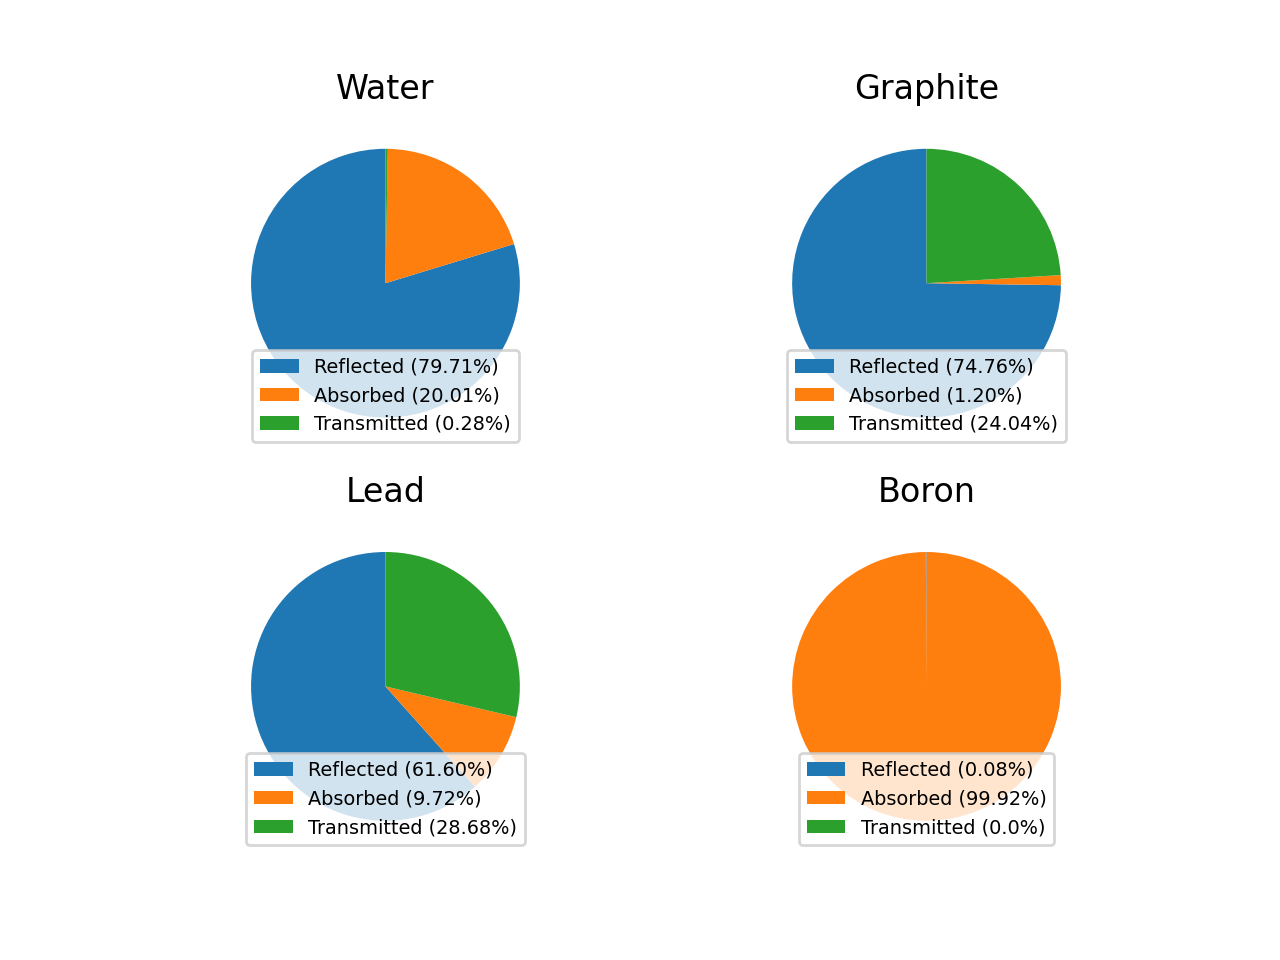

Text(0.5, 1.0, 'Boron')

In [53]:
thickness = 10
number_of_neutrons = 1000
runs = 10

def neutron_walks(sigma_a, sigma_s, density, mass, thickness, neutrons):
    """
    Performs random walks for many neutrons. Stores only relevant information regarding final postions/absorption and 
    discards anything else.
    
    args:
    
    sigma_a - float
    sigma_s - float
    density - float
    mass - float
    thickness - float
    neutrons - int
    
    returns:
    counter - array
    
    """
    reflected = 0
    absorbed = 0
    transmitted = 0
    step = 0
    positions = np.zeros(neutrons)
    absorption_probability = sigma_a / (sigma_a + sigma_s)
    
    while len(positions) > 0:
        if step == 0:
            vector = random_exponential(lower_limit, upper_limit, neutrons, density, mass, sigma_a, sigma_s)[0] #ensures first step is in x direction only
            
            positions += vector
            
            reflected += len(np.where(positions < 0)[0])
            transmitted += len(np.where(positions > thickness)[0])
            
            positions = np.delete(positions, np.hstack((np.where(positions < 0)[0], np.where(positions > thickness)[0])))
            
            probability = np.random.uniform(0, 1, len(positions))
            absorbed += len(np.where(probability < absorption_probability)[0])
            
            positions = np.delete(positions, np.where(probability < absorption_probability)[0])
            step += 1
            
            continue
        
        else:
            vector = [random_exponential_vector_generator(lower_limit, upper_limit, 1, density, mass, sigma_a, sigma_s)[0] for i in range(len(positions))]
            positions += vector
            
            reflected += len(np.where(positions < 0)[0])
            transmitted += len(np.where(positions > thickness)[0])
            
            positions = np.delete(positions, np.hstack((np.where(positions < 0)[0], np.where(positions > thickness)[0])))
            
            probability = np.random.uniform(0, 1, len(positions))
            absorbed += len(np.where(probability < absorption_probability)[0])
            
            positions = np.delete(positions, np.where(probability < absorption_probability)[0])
            step += 1
            
            continue
        
    counter = np.hstack((reflected, absorbed, transmitted))
    return counter

def walk_average(sigma_a, sigma_s, density, mass, thickness, neutrons, runs):
    """
    Averages previous function for a given number of runs
    
    args:
    
    sigma_a - float
    sigma_s - float
    density - float
    mass - float
    thickness - float
    neutrons - int
    runs - int
    
    returns:
    
    average_walk - array
    walk_error - array
    """
    
    walk = np.empty((runs, 3))
    
    for i in range(runs):
        
        new_walk = neutron_walks(sigma_a, sigma_s, density, mass, thickness, neutrons)
        walk[i] = new_walk
        
    average_walk = np.mean(walk, axis=0)
    walk_error = np.std(walk, axis=0)
    return average_walk, walk_error

water_avg_walk, water_walk_error = walk_average(water_sigma_a, water_sigma_s, water_density, water_molar_mass, thickness, number_of_neutrons, runs)
graphite_avg_walk, graphite_walk_error = walk_average(graphite_sigma_a, graphite_sigma_s, graphite_density, graphite_molar_mass, thickness, number_of_neutrons, runs)
lead_avg_walk, lead_walk_error = walk_average(lead_sigma_a, lead_sigma_s, lead_density, lead_molar_mass, thickness, number_of_neutrons, runs)
boron_avg_walk, boron_walk_error = walk_average(boron_sigma_a, boron_sigma_s, boron_density, boron_molar_mass, thickness, number_of_neutrons, runs)



fig = plt.figure()

ax = fig.add_subplot(221)
ax.pie(water_avg_walk/np.sum(water_avg_walk), startangle=90, normalize=False) 
ax.legend(['Reflected ({:4.2f}%)'.format(100*water_avg_walk[0]/np.sum(water_avg_walk)), 'Absorbed ({:4.2f}%)'.format(100*water_avg_walk[1]/np.sum(water_avg_walk)), 'Transmitted ({:4.2f}%)'.format(100*water_avg_walk[2]/np.sum(water_avg_walk))], loc='lower center', fontsize='x-small')
ax.set_title('Water')


ax = fig.add_subplot(222)
ax.pie(graphite_avg_walk/np.sum(graphite_avg_walk), startangle=90, normalize=False)
ax.legend(['Reflected ({:4.2f}%)'.format(100*graphite_avg_walk[0]/np.sum(graphite_avg_walk)), 'Absorbed ({:4.2f}%)'.format(100*graphite_avg_walk[1]/np.sum(graphite_avg_walk)), 'Transmitted ({:4.2f}%)'.format(100*graphite_avg_walk[2]/np.sum(graphite_avg_walk))], loc='lower center', fontsize='x-small')
ax.set_title('Graphite')


ax = fig.add_subplot(223)
ax.pie(lead_avg_walk/np.sum(lead_avg_walk), startangle=90, normalize=False)
ax.legend(['Reflected ({:4.2f}%)'.format(100*lead_avg_walk[0]/np.sum(lead_avg_walk)), 'Absorbed ({:4.2f}%)'.format(100*lead_avg_walk[1]/np.sum(lead_avg_walk)), 'Transmitted ({:4.2f}%)'.format(100*lead_avg_walk[2]/np.sum(lead_avg_walk))], loc='lower center', fontsize='x-small')
ax.set_title('Lead')

ax = fig.add_subplot(224)
ax.pie(boron_avg_walk/np.sum(boron_avg_walk), startangle=90, normalize=False)
ax.legend(['Reflected ({:.3}%)'.format(100*boron_avg_walk[0]/np.sum(boron_avg_walk)), 'Absorbed ({:.4}%)'.format(100*boron_avg_walk[1]/np.sum(boron_avg_walk)), 'Transmitted ({:.3}%)'.format(100*boron_avg_walk[2]/np.sum(boron_avg_walk))], loc='lower center', fontsize='x-small')
ax.set_title('Boron')

The figures above show the percentages of mechanisms in the materials. In each case most of the neutrons are reflected, excluding boron. This makes sense when we consider that each time a neutron is normally-incident to the material, its first random step has a 50/50 chance of moving in negative x direction, assuming it is not absorbed on the first step. Even if the first step is not in the negative x direction, it can still go there at some later time after a number of steps. This means that for a sufficient number of neutrons over many runs, we would expect over half of them to reflected. The reason that boron is exception to this is because its probability of absorption is so high. Using the previously stated equation, the absorption probability in boron is caluclated to be 0.9958, thus most neutrons are absorbed immediately upon entering the material and the walk ends abruptly, before the neutron has chance to take a step. 

Water is a good absorber of neutrons, absorbing ~20%, compared to graphite's and lead's 1% and 9% respectively. Water is also a good material for stopping the transmission of neutrons, with less than 1% of the neutrons making it through the slab. However boron is overwhelmingly the best at stopping neutrons, with ~99.9% being absorbed, and the remainder reflected. 


Revisiting the applications of neutron transmission, these results explain why enriched uranium must be used in nuclear reactors that use (light) water as a moderator. Water absorbs a significant fraction of the neutrons released in fission, so much so that it is impossible to achieve criticality (a sustained chain reaction) with natural uranium, thus enriched uranium must be used instead. It also explains why boron is used to construct control rods in nuclear reactors. Because they absorb so many neutrons, they can be used to regulate the reaction and ensure it stays at safe levels or, in the case of an emergency, attempt to stop it altogether.

## Variations In Error

This section will investigate how errors vary for the number of neutrons used per run.

<IPython.core.display.Javascript object>


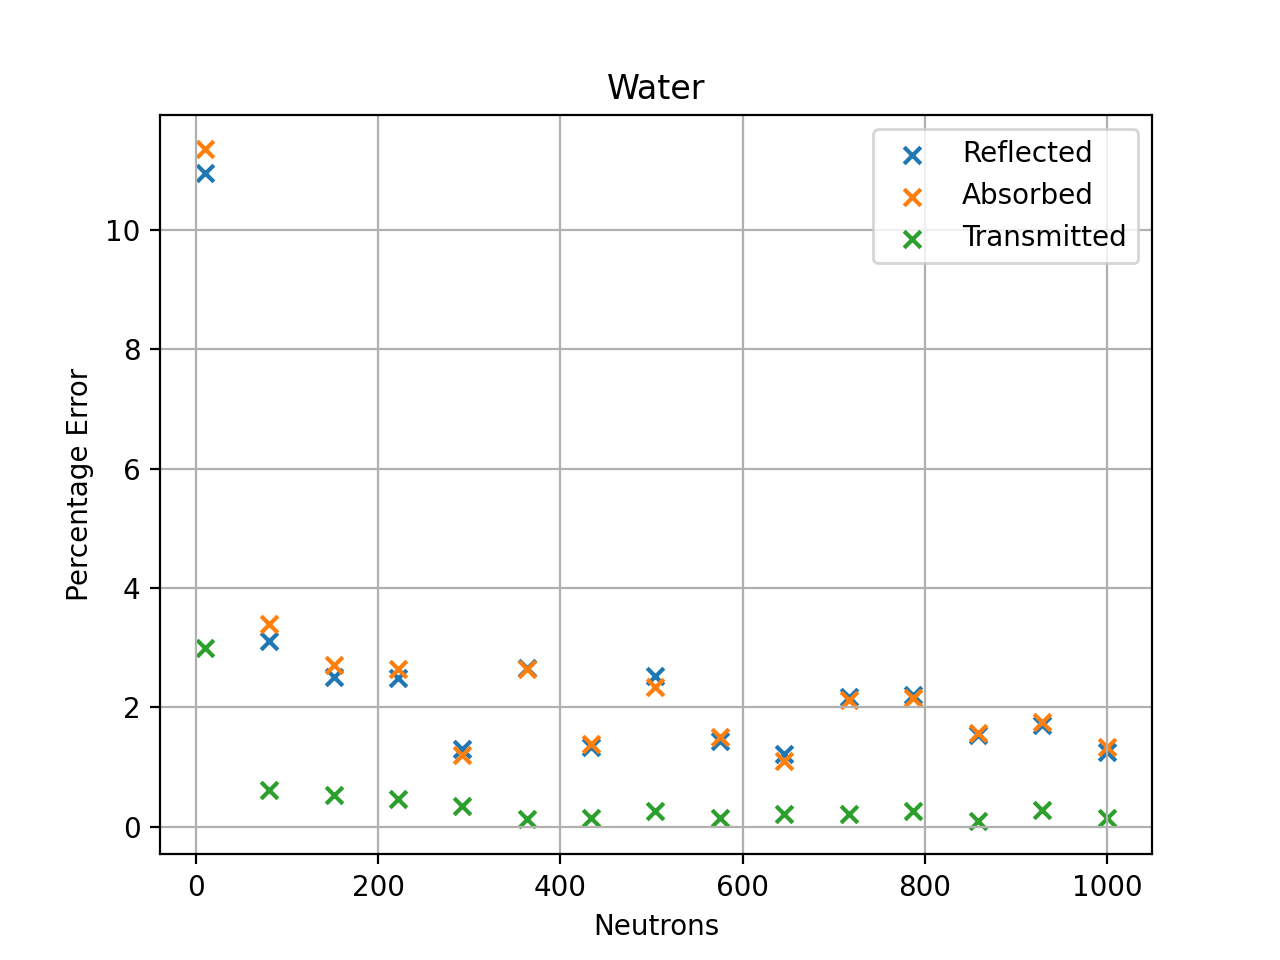

<IPython.core.display.Javascript object>


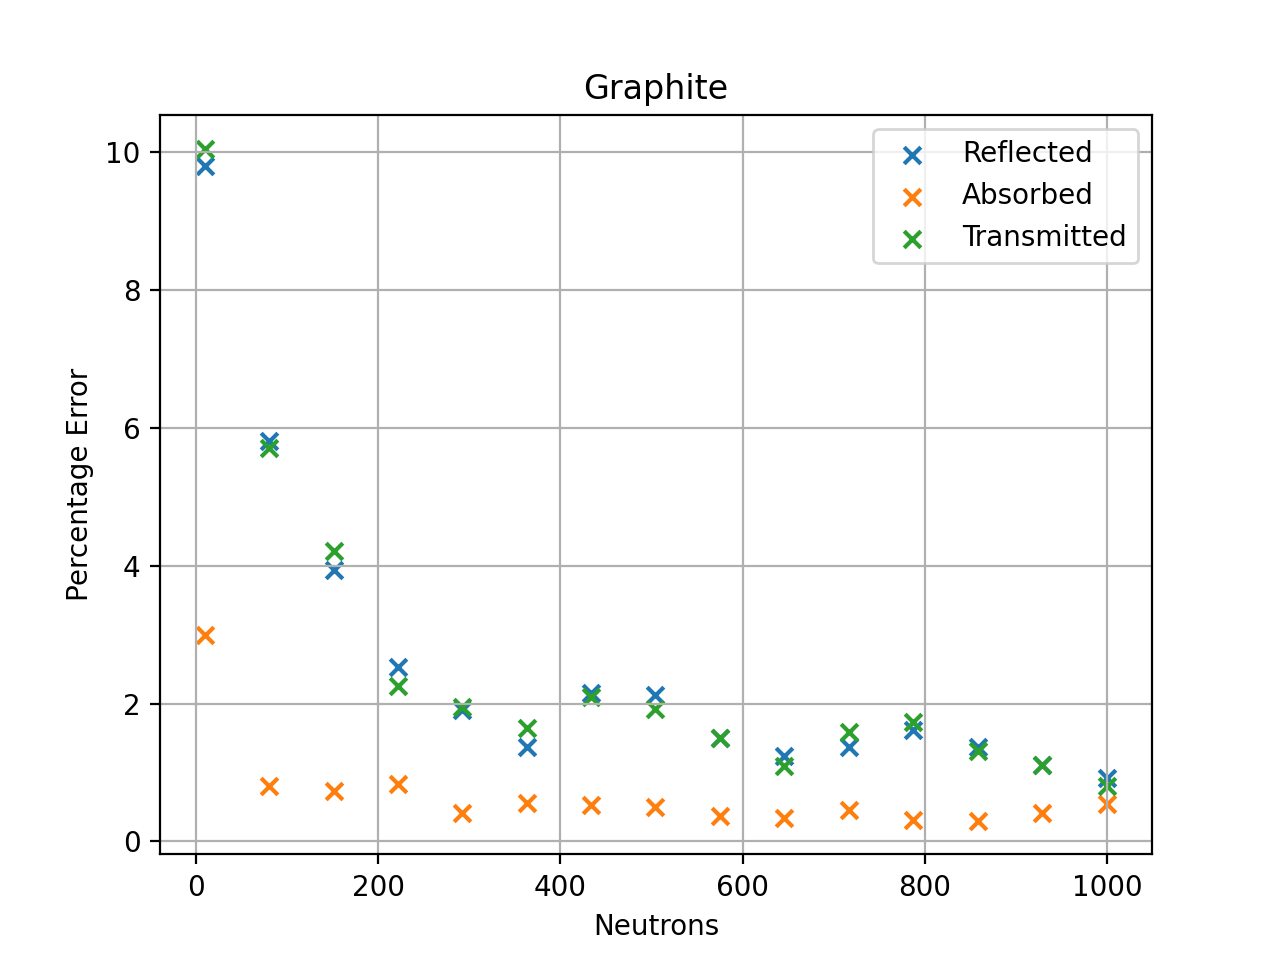

<IPython.core.display.Javascript object>


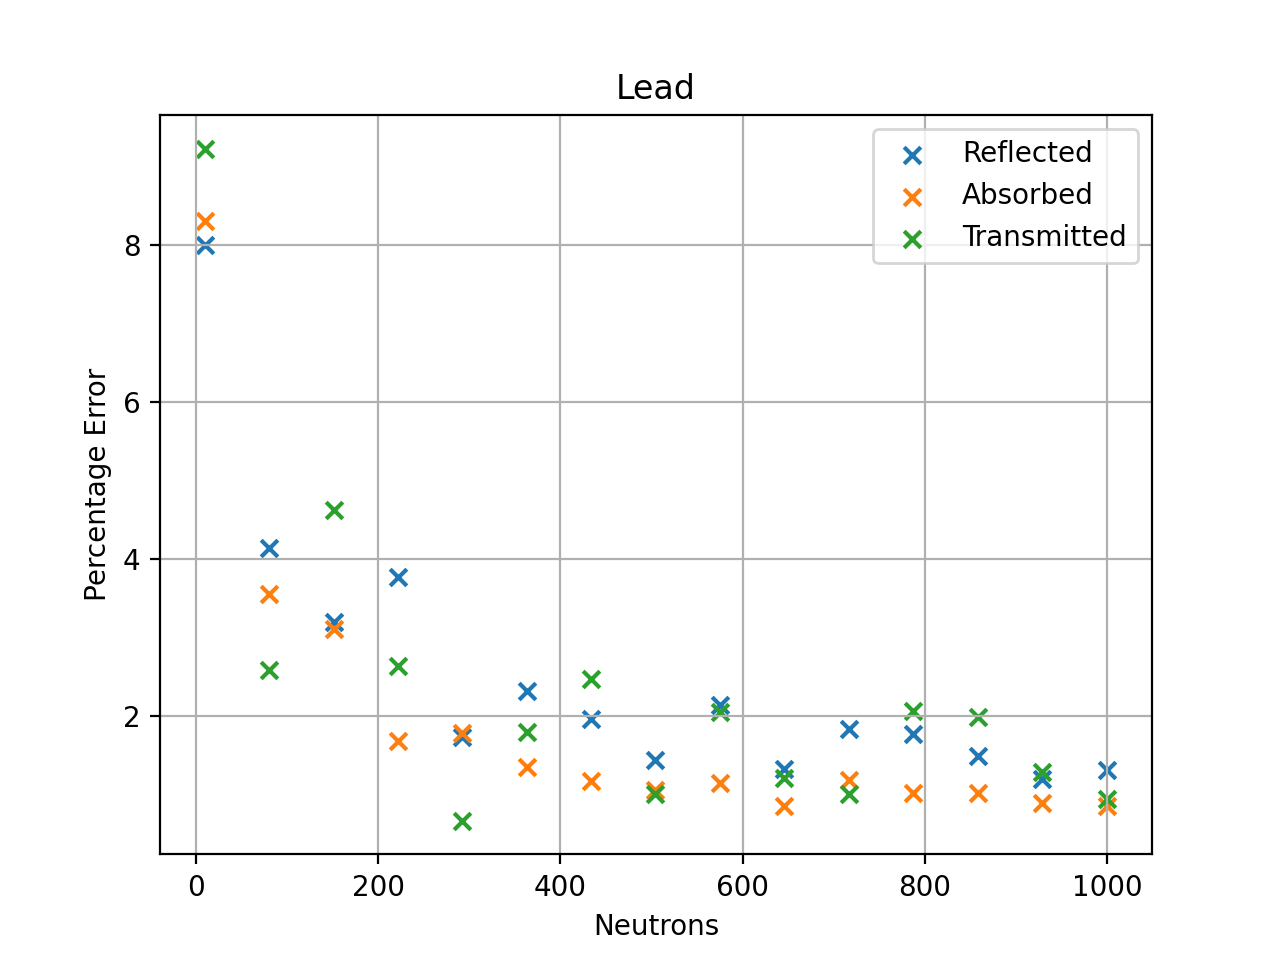

<IPython.core.display.Javascript object>


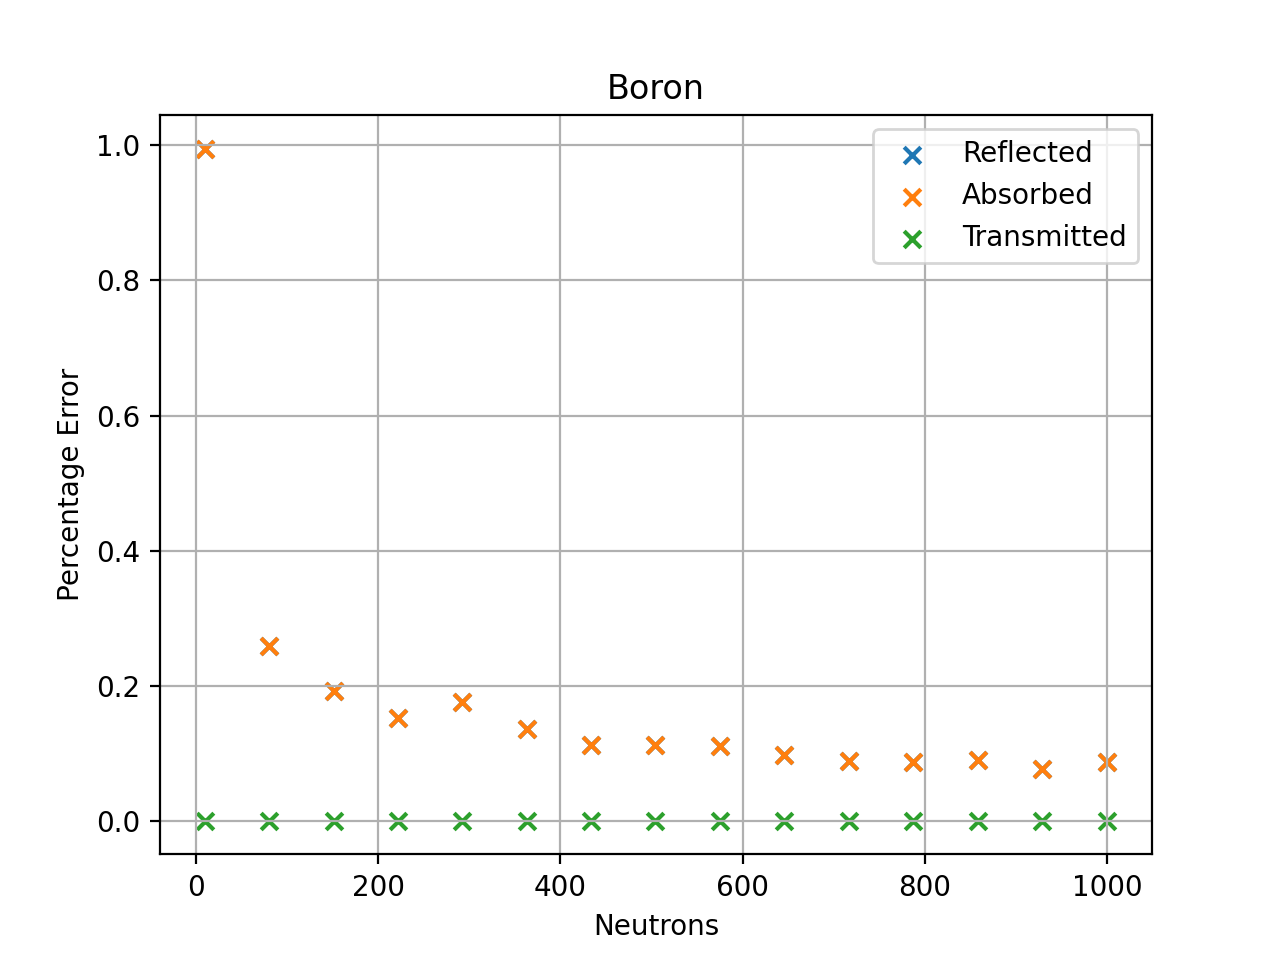

In [55]:
neutron_arr = np.linspace(10, 1000, 15)
neutron_arr = neutron_arr.astype(int)
runs = 10

def varying_neutron_error(sigma_a, sigma_s, density, mass, thickness, neutrons, runs, material):
    """
    Calculates the average counts for a range of neutrons per run.
    
    sigma_a - float
    sigma_s - float
    density - float
    mass - float
    thickness - float
    neutrons - int
    runs - int
    
    returns:
    
    count_diff_neutron - array
    error_diff_neutron - array
    
    """

    count_diff_neutron = np.empty((len(neutrons), 3))
    error_diff_neutron = np.empty((len(neutrons), 3))

    for i in range(len(neutrons)):
    
        count, error = walk_average(sigma_a, sigma_s, density, mass, thickness, neutrons[i], runs)
        count_diff_neutron[i] = count
        error_diff_neutron[i] = error

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(neutron_arr, 100*error_diff_neutron[:, 0]/neutron_arr, label='Reflected', marker='x')
    ax.scatter(neutron_arr, 100*error_diff_neutron[:, 1]/neutron_arr, label='Absorbed', marker='x')
    ax.scatter(neutron_arr, 100*error_diff_neutron[:, 2]/neutron_arr, label='Transmitted', marker='x')
    ax.set_title('{}'.format(material))
    ax.legend()
    ax.set_ylabel('Percentage Error')
    ax.set_xlabel('Neutrons')
    ax.grid()
    plt.show()


    
    
    
    
varying_neutron_error(water_sigma_a, water_sigma_s, water_density, water_molar_mass, thickness, neutron_arr, runs, 'Water')
varying_neutron_error(graphite_sigma_a, graphite_sigma_s, graphite_density, graphite_molar_mass, thickness, neutron_arr, runs, 'Graphite')
varying_neutron_error(lead_sigma_a, lead_sigma_s, lead_density, lead_molar_mass, thickness, neutron_arr, runs, 'Lead')
varying_neutron_error(boron_sigma_a, boron_sigma_s, boron_density, boron_molar_mass, thickness, neutron_arr, 200, 'Boron')



Each plot shows the same curve - this is due to the statistical nature of the errors on the count. The count is dictated by Poisson statistics, which means that, for sufficiently large N, the sample mean will be normally distributed due to the central limit theorem, which is then given by $\sqrt{N}$, where N is the count. Therefore, the percentage error curves on the plot follow $\delta = \frac{1}{\sqrt{N}}$. This can be seen in the figures above, even with a limited numbers of points being plotted.

Because of borons exceptionally ability to absorb neutrons, it is necessary to run the simulation more than others, as the errors widly fluctuate until averaged a sufficient number of times. Also because of boron's absorption capabilities, the transmission and reflection counts are very consistent (~0%) thus their error curves lie unresolvably close to 0.

## Characteristic Attenuation Length

In this section the characteristic attenuation lengths of the different materials will be calculated. The previously used functions will be used but for varying thicknesses and the number of neutrons transmitted will be fit to a straight line via a least squares method. This approach is the same as that used previously when showing that attenuation length is 45 cm in water when scattering is not considered, except all mechanisms will be considered this time. 

<IPython.core.display.Javascript object>


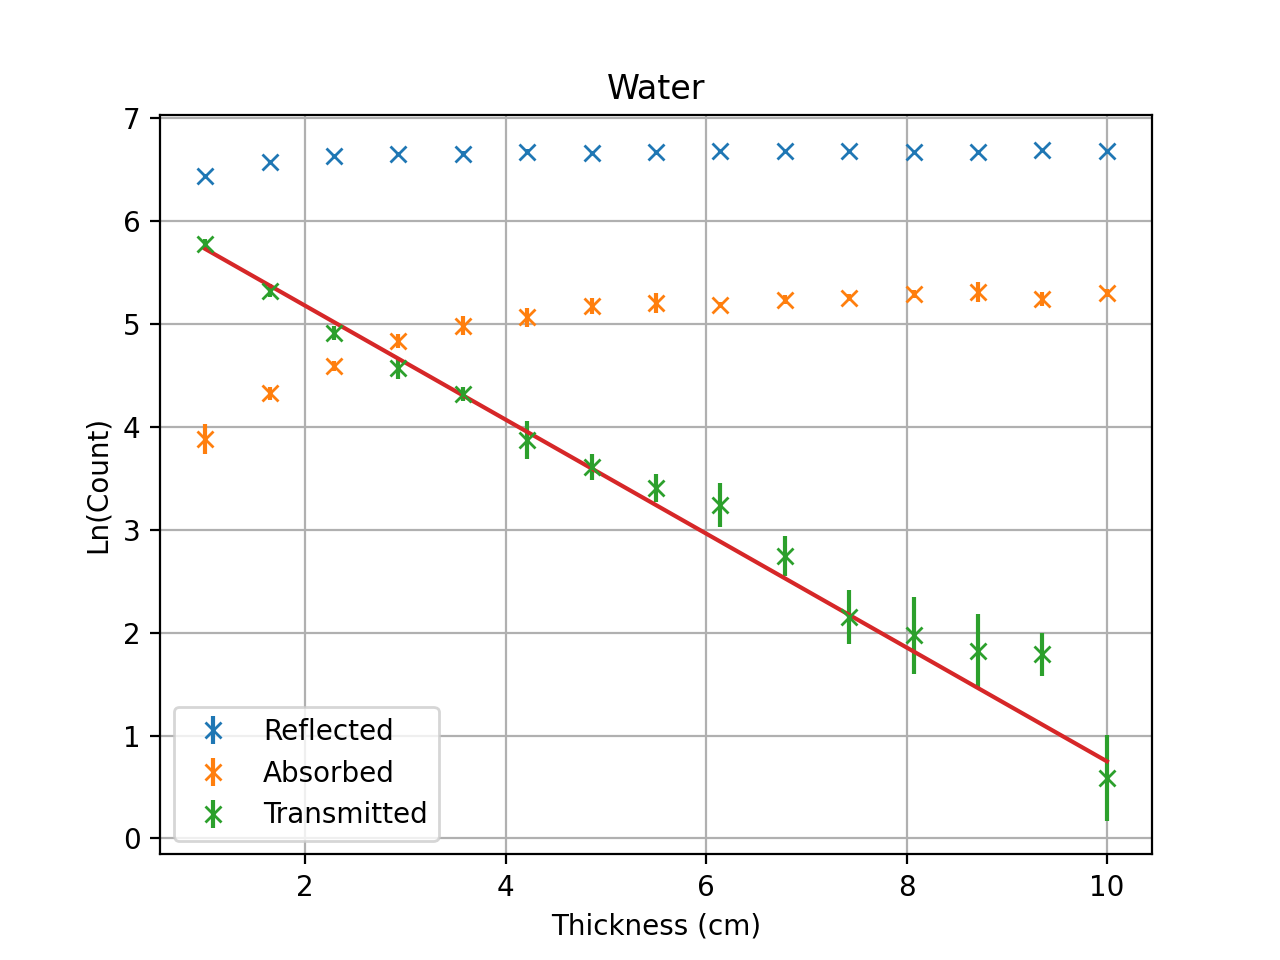

The characteristic attenuation length of neutrons in Water is 1.806 +- 0.063 cm


<IPython.core.display.Javascript object>


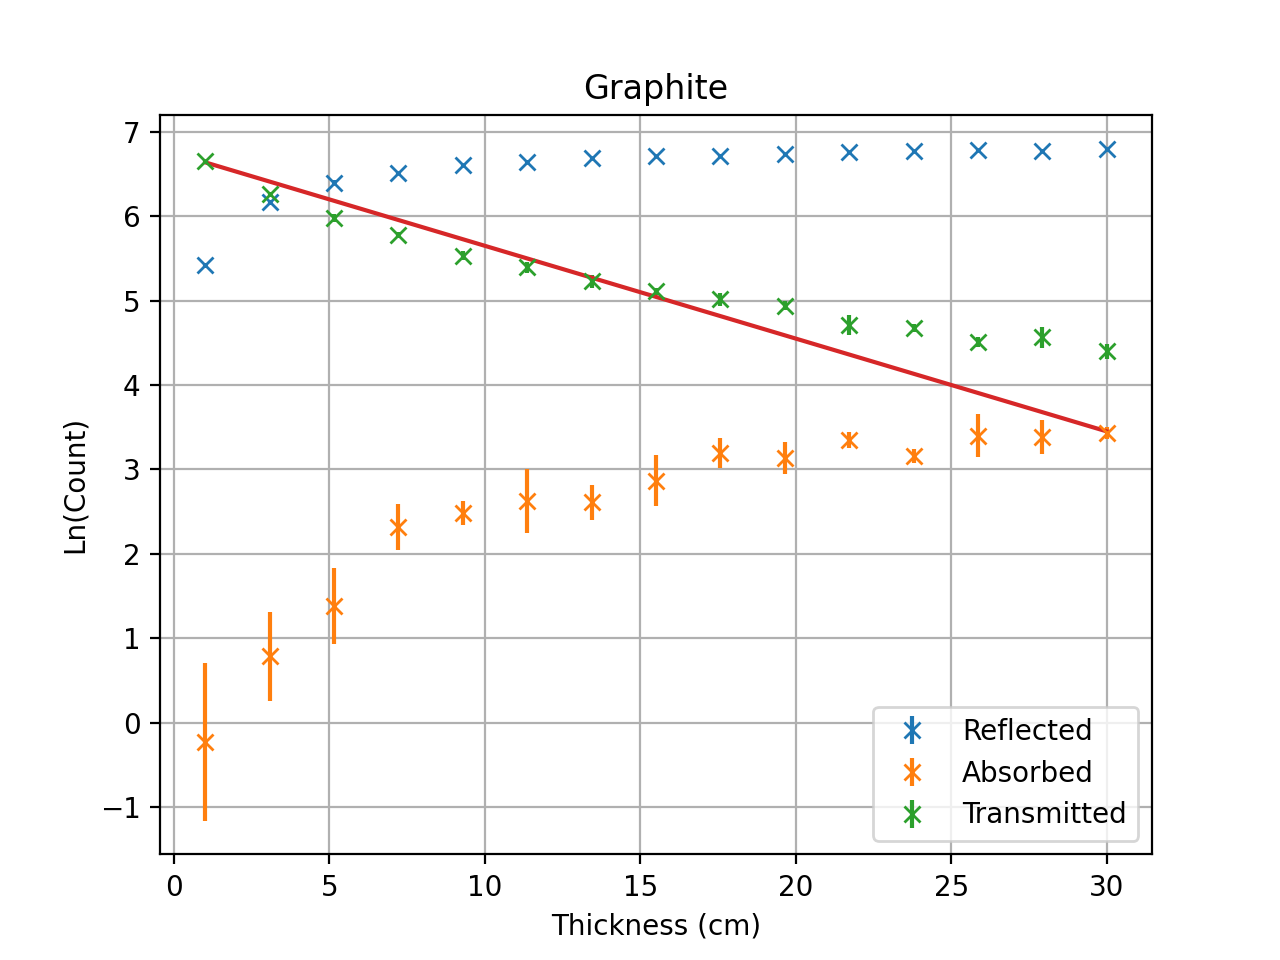

The characteristic attenuation length of neutrons in Graphite is 9.104 +- 0.593 cm


<IPython.core.display.Javascript object>


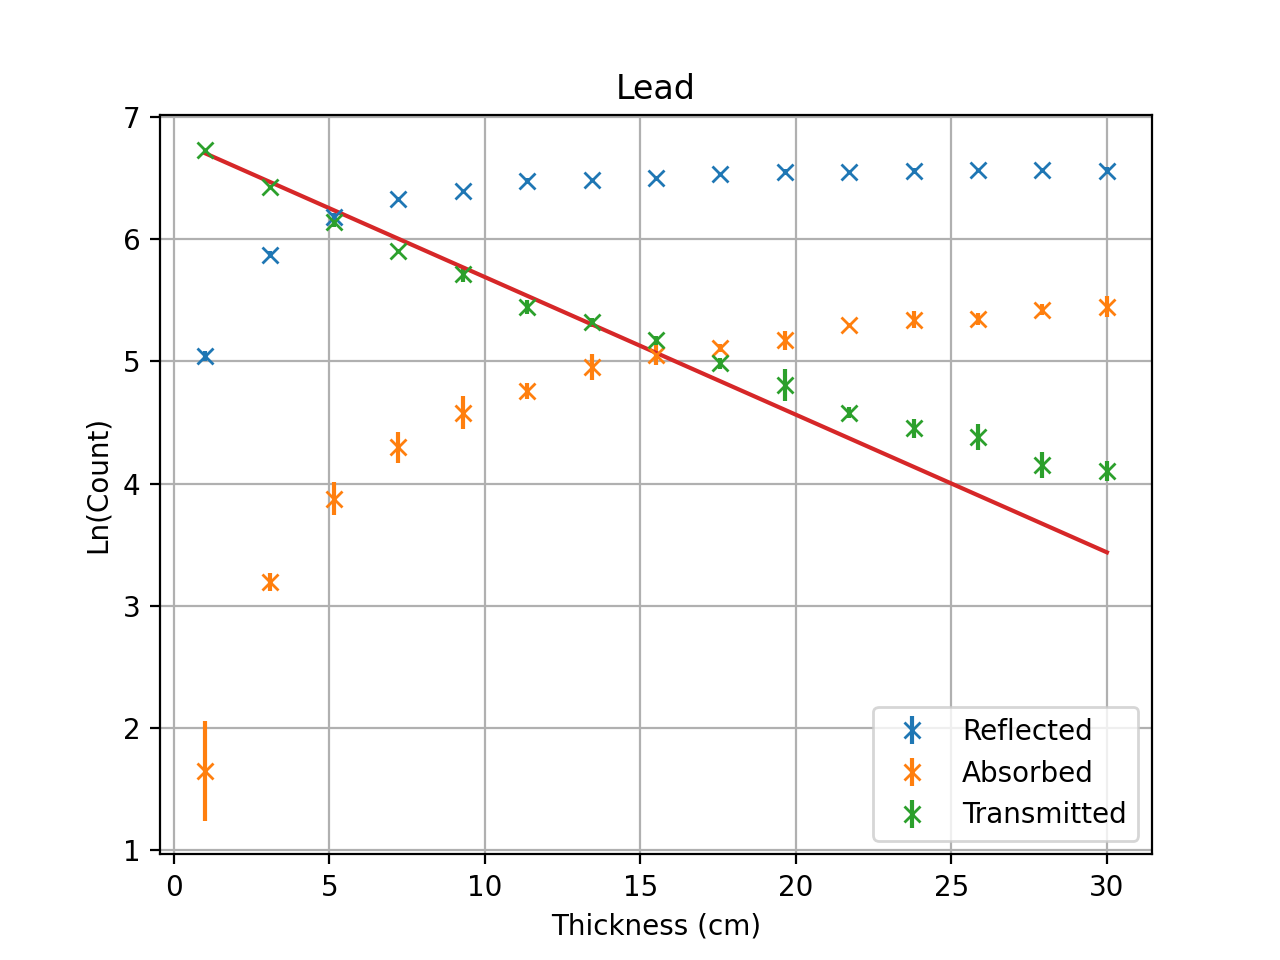

The characteristic attenuation length of neutrons in Lead is 8.872 +- 0.361 cm


<IPython.core.display.Javascript object>


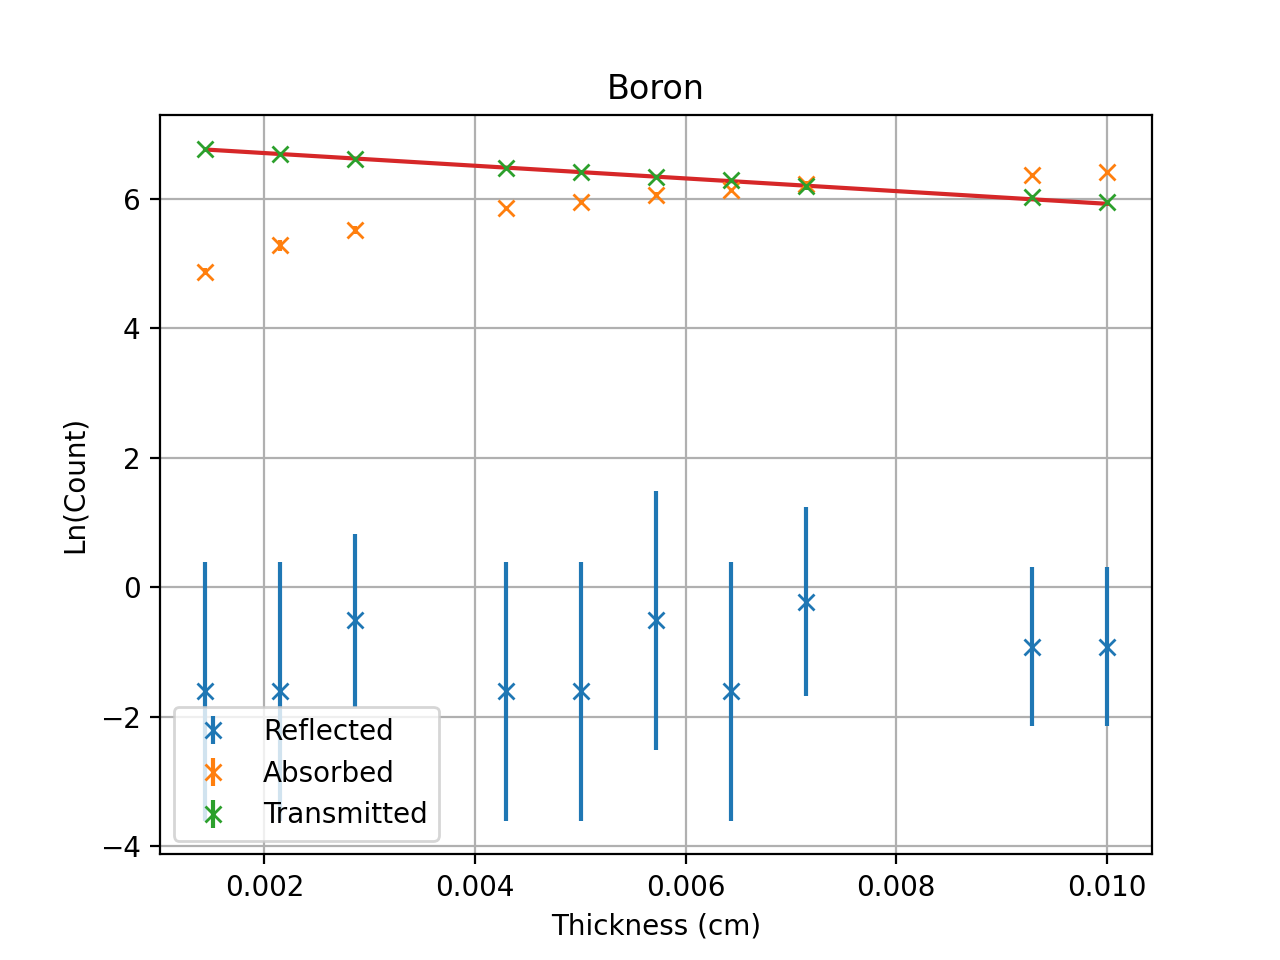

The characteristic attenuation length of neutrons in Boron is 0.0102 +- 0.000147 cm


In [56]:
water_thicknesses = np.linspace(1, 10, 15)
graphite_thicknesses = np.linspace(1, 30, 15)
lead_thicknesses = np.linspace(1, 30, 15)
boron_thicknesses = np.linspace(0.00001, 0.01, 15)
runs=5

def varying_thickness(sigma_a, sigma_s, density, mass, thicknesses, neutrons, runs):
    """
    Calculates the average counts for a range of thicknesses.
    
    sigma_a - float
    sigma_s - float
    density - float
    mass - float
    thickness - float
    neutrons - int
    runs - int
    
    returns:
    
    count_diff_thick - array
    error_diff_thick - array
    
    """
    
    count_diff_thick = np.empty((len(thicknesses), 3))
    error_diff_thick = np.empty((len(thicknesses),3))
    
    
    for i in range(len(thicknesses)):
        
        count, error = walk_average(sigma_a, sigma_s, density, mass, thicknesses[i], neutrons, runs)
        
        count_diff_thick[i] = count
        error_diff_thick[i] = error
    
    
    return count_diff_thick, error_diff_thick

def log_convert(count, error):
    """
    Takes the natural log of the count and propagates error.
   
    args:
    
    count - array
    error - array
    
    returns:
    
    ln_count - array
    ln_error - array
    """
    
    ln_count = np.log(count)
    ln_error = error / count
    
    return ln_count, ln_error


def varying_thickness_plot(sigma_a, sigma_s, density, mass, thicknesses, neutrons, runs, material):
    
    diff_thick_count, diff_thick_error = varying_thickness(sigma_a, sigma_s, density, mass, thicknesses, neutrons, runs)

    delete = np.where(diff_thick_count == 0)[0]
    
    diff_thick_count = np.delete(diff_thick_count, delete, 0)
    diff_thick_error = np.delete(diff_thick_error, delete, 0)
    thicknesses = np.delete(thicknesses, delete, 0)

    ln_diff_thick_count, ln_diff_thick_error = log_convert(diff_thick_count, diff_thick_error)

    cutoff_index = int(len(thicknesses) * 0.75)
    
    coeff, char_length, char_length_error = linear_fit(ln_diff_thick_count[:cutoff_index, 2], thicknesses[:cutoff_index], ln_diff_thick_error[:cutoff_index, 2])

    y = straight_line(coeff[0], thicknesses, coeff[1])
    
    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.errorbar(thicknesses, ln_diff_thick_count[:, 0], yerr=ln_diff_thick_error[:, 0], label='Reflected', fmt='x')
    ax.errorbar(thicknesses, ln_diff_thick_count[:, 1], yerr=ln_diff_thick_error[:, 1], label='Absorbed', fmt='x')
    ax.errorbar(thicknesses, ln_diff_thick_count[:, 2], yerr=ln_diff_thick_error[:, 2], label='Transmitted', fmt='x')
    ax.plot(thicknesses, y)
    ax.legend()
    ax.set_xlabel('Thickness (cm)')
    ax.set_ylabel('Ln(Count)')
    ax.set_title('{}'.format(material))
    ax.grid()
    plt.show()

    print('The characteristic attenuation length of neutrons in {0} is {1:.4g} +- {2:.3g} cm'.format(material, char_length, char_length_error))

varying_thickness_plot(water_sigma_a, water_sigma_s, water_density, water_molar_mass, water_thicknesses, number_of_neutrons, runs, 'Water')
varying_thickness_plot(graphite_sigma_a, graphite_sigma_s, graphite_density, graphite_molar_mass, graphite_thicknesses, number_of_neutrons, runs, 'Graphite')
varying_thickness_plot(lead_sigma_a, lead_sigma_s, lead_density, lead_molar_mass, lead_thicknesses, number_of_neutrons, runs, 'Lead')
varying_thickness_plot(boron_sigma_a, boron_sigma_s, boron_density, boron_molar_mass, boron_thicknesses, number_of_neutrons, runs, 'Boron')
    


Using a polyfit, the gradient of each transmission line was calculated, with the negative inverse being equal to the characteristic attenuation length. Graphite yields the greatest value, which is expected given that it was a poor absorber and transmitted approximately 25% of neutrons previously. Boron has lowest value of characteristic attenuation (~0.01 cm), which is 2-3 orders of magnitude smaller than the other materials. This is also expected as boron absorbs almost all neutrons and transmits only at exceptionaly small thicknesses, approximately 4-5 orders of magnitude smaller than the other thicknesses used. This means that when control rods are used to stop the transmission of neutrons, they do not have to be very thick and only a large surface area is required to achieve the desired effect.

It can be seen that the characteristic attenaution length values differ from mean free path. The characteristic attenuation gives the distance that a neutron has travelled into the material when the probability of it $not$ being absorbed has dropped to 1/e. By this definition boron will obviously have the shortest length, as it has the largest macroscopic cross section. This differs from mean free path as this is simply the average distance the particle will travel before interacting with the material.

The error bars for transmission on each plot, where visible, increase in size at greater thicknesses. This is because neutrons are less likely to be transmitted at greater thicknesses, so the number of neutrons that are transmitted largely fluctuates and the error bars grow. The opposite happens for absorption. Neutrons are more likely to be absorbed at greater thicknesses (as they spend more time in the material) thus the error bars decrease in size.

It can be seen that lead has the second largest characteristic attenuation length, which may seem unusual at first given that lead is used to store radioactive material and block gamma rays. This, however, has already been addressed. Neutrons have no charge and so are not affected by the Coloumb field, meaning what is good at stopping gamma rays is not neccessarily good at stopping neutrons.

## Woodcock Method

The woodcock method is a method used to determine the rates of transmission through through two slabs of different materials in contact with each other. This is a necessary addition to improve the applicability of the neutron transmission model. Many of geometries of the real world are not as simple as those studied so far, so being able to simulate for different materials simultaneously is a crucial first step in creating a more applicable model. Examples of these applications include medical imaging and reactor core shielding. 

One way of creating three dimensional images of the body uses neutrons that will be absorbed at different rates by the different tissues in the body. The multiple measurements taken from different angles are then processed on a computer using reconstruction algorithms to produce tomographic (cross-sectional) images of a body. These images can then be put together to form a 3D model. 

Understanding how neutrons travel through different adjacent materials also helps in shielding from neutron radiation. Since blocking the neutron can cause low-density material to release gamma rays, it’s best to use a protective barrier with both low and high-density materials.
Low-density material can cause gamma-rays to scatter, and high-density material can prevent the gamma-ray from even being released. A combination of the two creates a very good shield against both types of radiation.

Now that two materials are being considered at once, the key difference (other than simply the different scattering/absorption probabilties) is that steps across the boundary are incorrect. The steps in material 1 are distributed according to the mean free path $\lambda_{1}$, and the steps in material 2 are distributed according to $\lambda_{2}$. This means that steps accross the boundary introduces statistcal bias that must be adjusted for, with this process known as ficticious tracking.

We must divide this initial step (across the boundary) into many smaller steps that are all still in the same direction as the original. This process is repeated until the boundary has been crossed.

An example of lead to water, each of thickness 10 cm,
is shown below.

In [ ]:
def woodcock_method(sigma_a_1, sigma_s_1, density_1, mass_1, sigma_a_2, sigma_s_2, density_2, mass_2, T, neutrons):
    
    absorption_probability_1 = sigma_a_1 / (sigma_a_1 + sigma_s_1)
    absorption_probability_2 = sigma_a_2 / (sigma_a_2 + sigma_s_2)
    
    
    reflected_counter = 0
    absorbed_counter = 0
    transmitted_counter = 0
    
    
    
        
    while neutrons > 0:
        stop = False
        position = [0, 0, 0]
        step = random_exponential(lower_limit, upper_limit, 1, density_2, mass_2, sigma_a_2, sigma_s_2)[0] #ensures first step is in x direction only
        position =  position + step
        
        while not stop and position[0] < 2*T and position[0] > 0:
            if position[0] < T and position[0] > 0:
                probability = np.random.uniform(0, 1, 1)
                if probability > ((sigma_a_1 + sigma_s_1)/(sigma_a_2 + sigma_s_2)):
                    unit_vector = position / np.sum(position)
                    fic_step = random_exponential(lower_limit, upper_limit, 1, density_2, mass_2, sigma_a_2, sigma_s_2)[0] * unit_vector
                    position += fic_step
                else:
                    probability = np.random.uniform(0, 1, 1)
                    if probability < absorption_probability_1:
                        absorbed_counter += 1
                        neutrons -=1
                        stop = True
                    else:
                        step = random_exponential_vector_generator(lower_limit, upper_limit, 1, density_2, mass_2, sigma_a_2, sigma_s_2)[0] #ensures first step is in x direction only
                        position += step
            elif position[0] > T and position[0] < 2*T:
                probability = np.random.uniform(0, 1, 1)
                if probability < absorption_probability_2:
                    absorbed_counter += 1
                    neutrons -=1
                    stop = True
                else:
                    step = random_exponential_vector_generator(lower_limit, upper_limit, 1, density_2, mass_2, sigma_a_2, sigma_s_2)[0] #ensures first step is in x direction only
                    position += step
                        
        if position[0] < 0:
            reflected_counter += 1
            neutrons -= 1
            stop = True 
        else:
            transmitted_counter += 1
            neutrons -= 1
            stop = True
            
    counter = np.hstack((reflected_counter, absorbed_counter, transmitted_counter))
    
    return counter

woodcock_lead_water = [woodcock_method(lead_sigma_a, lead_sigma_s, lead_density, lead_molar_mass, water_sigma_a, water_sigma_s, water_density, water_molar_mass, 10, 1000) for i in range(10)]
lead_water_error = np.std(woodcock_lead_water, axis=0)
woodcock_lead_water = np.mean(woodcock_lead_water, axis=0)

print('The rates of reflection, absorption and scattering in lead to water are {0:4.2f}%, {1:4.2f}% and {2:4.2f}% respectively.'.format(100*woodcock_lead_water[0]/np.sum(woodcock_lead_water), 100*woodcock_lead_water[1]/np.sum(woodcock_lead_water), 100*woodcock_lead_water[2]/np.sum(woodcock_lead_water)))

## Neutron Resonance

The probability that a neutron will interact with nuclei strongly depends on the energy of the incoming neutron. Throughout this project only thermal neutrons that interact via absorption and scattering have been considered. In this final section we will consider fast neutrons (energies of order MeV) that interact with some total cross section $\sigma_{T}$. This is the sum of all partial cross sections given by

$$\sigma_{T} = \sigma_{scatter} + \sigma_{absorb} + \sigma_{fission} + \sigma_{radiative \ capture} \  +  \ ...$$

The cross sections reveal the presence of resonances, which are related to excited states of the compound nucleus just above the energy required to remove the neutron from the nucleus, know as the separation energy. These resonances are particularly prominent in gold, thus we can investigate how incident neutron energy dictates the interactions in gold.

<IPython.core.display.Javascript object>


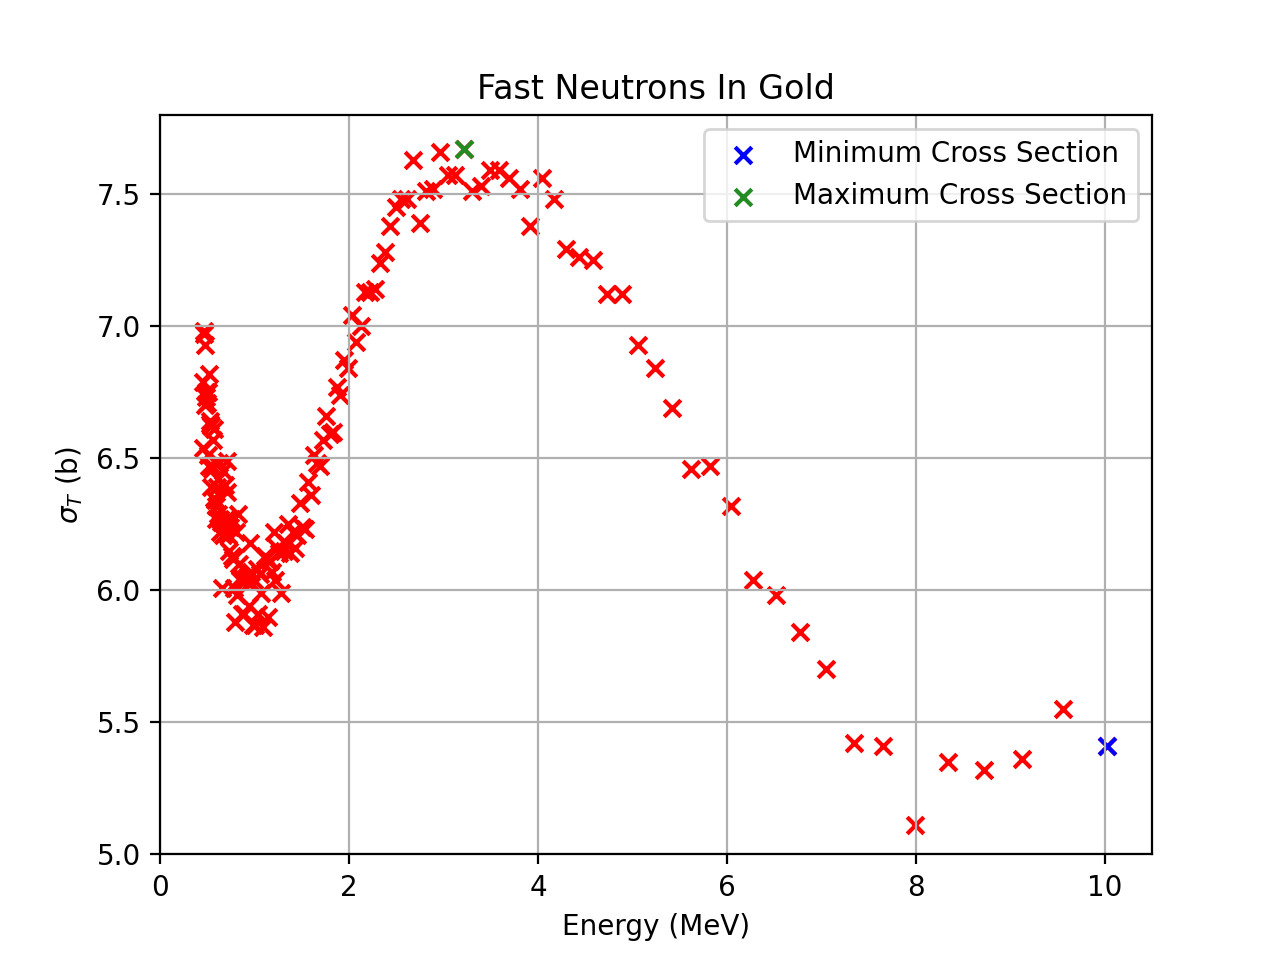

<IPython.core.display.Javascript object>


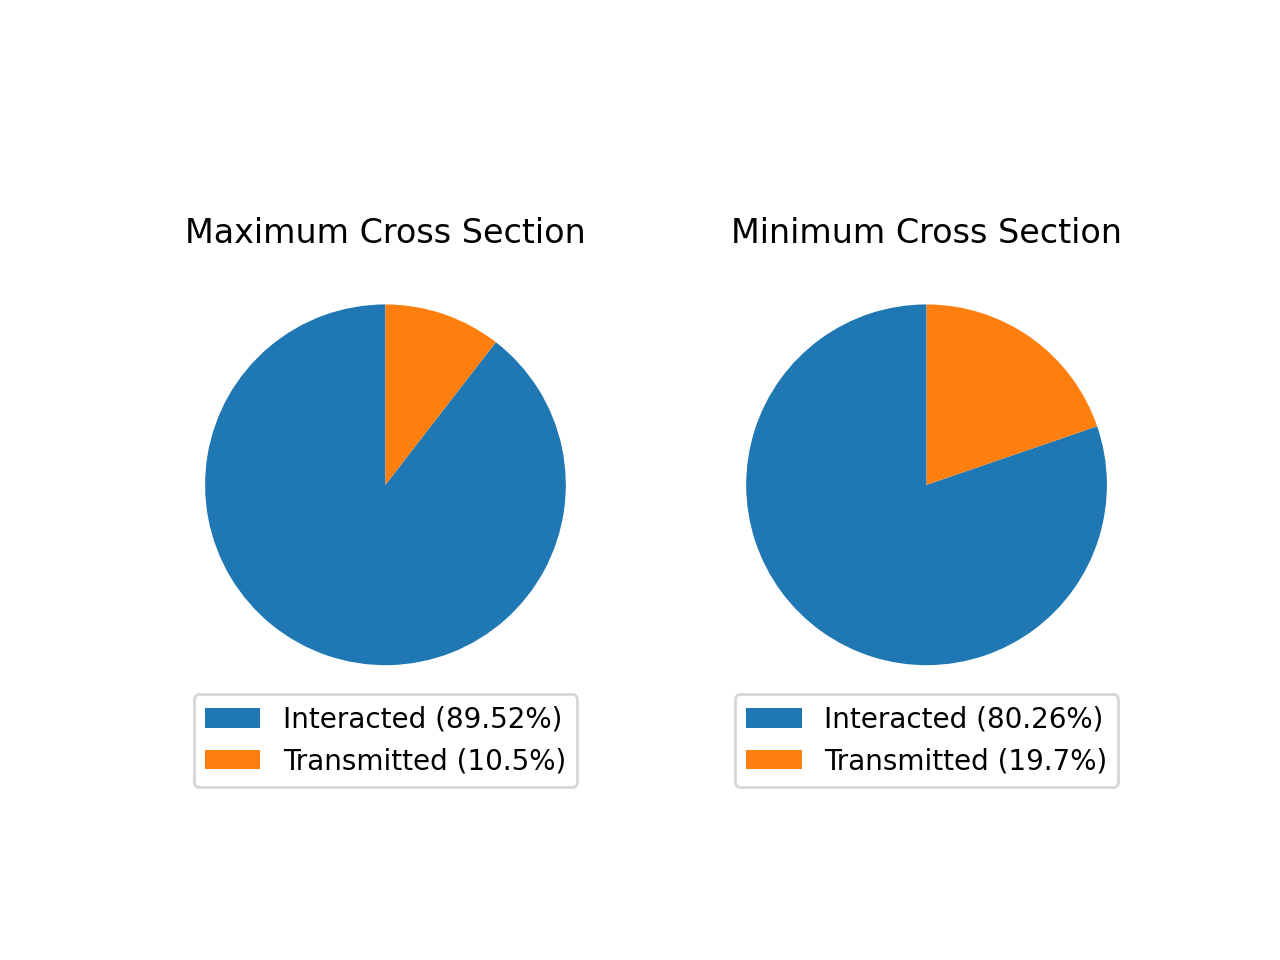

Text(0.5, 1.0, 'Minimum Cross Section')

In [57]:
gold_density = 19.32 #g/cm^3
gold_molar_mass = 196.96 #g/mol
thickness = 5
gold_thicknesses = np.arange(1, 15, 15)

gold_data = '0.200 8.91 0.74 0.201 8.87 0.71 0.202 9.12 0.69 0.204 8.15 0.69 0.205 8.33 0.64 0.206 9.04 0.63 0.208 9.22 0.66 0.209 8.20 0.74 0.211 7.93 0.74 0.212 9.18 0.67 0.214 9.68 0.63 0.215 8.54 0.60 0.217 8.28 0.58 0.218 7.74 0.58 0.220 8.23 0.58 0.221 7.94 0.63 0.223 9.37 0.61 0.225 8.64 0.59 0.226 8.71 0.57 0.228 8.33 0.58 0.229 8.08 0.59 0.231 8.12 0.59 0.233 7.17 0.55 0.234 8.58 0.53 0.236 8.65 0.53 0.238 7.68 0.52 0.240 8.82 0.49 0.241 8.20 0.50 0.243 8.30 0.49 0.245 8.13 0.49 0.247 8.73 0.45 0.249 8.21 0.45 0.251 7.95 0.42 0.253 9.18 0.36 0.254 8.77 0.34 0.256 8.49 0.39 0.258 8.77 0.46 0.260 8.47 0.46 0.262 8.23 0.46 0.264 7.58 0.46 0.267 7.99 0.45 0.269 8.14 0.44 0.271 8.42 0.43 0.273 7.94 0.41 0.275 7.93 0.40 0.277 7.95 0.43 0.279 8.70 0.43 0.282 7.56 0.40 0.284 7.66 0.41 0.286 7.82 0.39 0.289 7.12 0.38 0.291 7.92 0.37 0.293 8.04 0.36 0.296 8.55 0.35 0.298 7.47 0.36 0.301 7.51 0.36 0.303 7.68 0.35 0.306 8.15 0.34 0.308 7.32 0.33 0.311 7.89 0.31 0.313 7.66 0.28 0.316 7.66 0.31 0.319 8.30 0.35 0.321 7.21 0.34 0.324 7.35 0.32 0.327 7.96 0.30 0.330 7.85 0.30 0.333 6.95 0.29 0.336 7.59 0.30 0.339 7.49 0.29 0.342 7.84 0.28 0.345 7.78 0.28 0.348 7.85 0.28 0.351 7.39 0.33 0.354 7.66 0.37 0.357 7.07 0.34 0.360 7.18 0.30 0.364 7.06 0.29 0.367 7.22 0.28 0.370 7.43 0.27 0.374 6.88 0.26 0.377 6.80 0.26 0.381 7.00 0.24 0.384 7.50 0.26 0.388 7.42 0.26 0.392 7.00 0.24 0.395 6.71 0.23 0.399 6.86 0.24 0.403 7.08 0.24 0.407 7.08 0.24 0.411 7.32 0.23 0.415 6.62 0.23 0.419 6.87 0.21 0.423 7.06 0.21 0.427 6.73 0.22 0.431 7.15 0.23 0.436 7.14 0.22 0.440 7.22 0.20 0.444 6.79 0.20 0.449 6.88 0.20 0.453 6.79 0.20 0.458 6.54 0.19 0.463 6.97 0.18 0.468 6.98 0.18 0.472 6.70 0.19 0.477 6.93 0.18 0.482 6.73 0.17 0.487 6.75 0.17 0.493 6.71 0.17 0.498 6.75 0.16 0.503 6.75 0.16 0.509 6.51 0.16 0.514 6.82 0.16 0.520 6.47 0.16 0.525 6.64 0.19 0.531 6.63 0.18 0.537 6.62 0.15 0.543 6.39 0.15 0.549 6.47 0.15 0.555 6.46 0.15 0.562 6.57 0.16 0.568 6.35 0.15 0.574 6.61 0.15 0.581 6.34 0.15 0.588 6.27 0.14 0.595 6.32 0.14 0.602 6.39 0.13 0.609 6.29 0.12 0.616 6.42 0.14 0.623 6.48 0.13 0.631 6.27 0.13 0.638 6.22 0.14 0.646 6.26 0.12 0.654 6.01 0.13 0.662 6.45 0.13 0.670 6.21 0.13 0.679 6.25 0.12 0.687 6.40 0.12 0.696 6.27 0.12 0.705 6.49 0.12 0.714 6.37 0.12 0.723 6.21 0.13 0.732 6.15 0.12 0.742 6.24 0.11 0.751 6.27 0.11 0.761 6.13 0.11 0.771 6.12 0.11 0.782 6.01 0.11 0.792 5.88 0.11 0.803 6.22 0.10 0.814 5.98 0.12 0.825 6.29 0.12 0.837 6.10 0.10 0.848 6.04 0.10 0.860 6.05 0.11 0.872 5.91 0.10 0.885 5.91 0.10 0.897 6.04 0.09 0.910 6.04 0.09 0.923 6.05 0.09 0.937 5.94 0.09 0.951 6.18 0.09 0.965 6.07 0.09 0.979 5.87 0.09 0.994 6.04 0.09 1.009 5.87 0.09 1.025 6.08 0.09 1.041 5.91 0.09 1.057 6.06 0.09 1.073 5.99 0.08 1.090 5.86 0.08 1.108 6.13 0.08 1.125 6.12 0.08 1.144 5.90 0.08 1.162 6.11 0.08 1.181 6.07 0.08 1.201 6.22 0.08 1.221 6.04 0.08 1.242 6.16 0.08 1.263 6.14 0.07 1.285 5.99 0.08 1.307 6.15 0.07 1.330 6.18 0.07 1.353 6.25 0.07 1.377 6.14 0.07 1.402 6.22 0.07 1.427 6.16 0.07 1.453 6.21 0.07 1.480 6.33 0.07 1.507 6.24 0.07 1.536 6.23 0.07 1.565 6.41 0.07 1.595 6.36 0.07 1.626 6.51 0.07 1.657 6.48 0.07 1.690 6.47 0.07 1.724 6.57 0.07 1.758 6.66 0.07 1.794 6.59 0.06 1.831 6.60 0.06 1.869 6.77 0.06 1.908 6.74 0.06 1.948 6.87 0.07 1.990 6.84 0.06 2.033 7.04 0.06 2.077 6.94 0.06 2.123 7.00 0.06 2.171 7.13 0.06 2.220 7.13 0.06 2.270 7.14 0.07 2.323 7.24 0.07 2.377 7.28 0.07 2.434 7.38 0.07 2.492 7.45 0.07 2.552 7.48 0.07 2.615 7.48 0.07 2.680 7.63 0.07 2.748 7.39 0.07 2.818 7.51 0.07 2.890 7.52 0.07 2.966 7.66 0.07 3.045 7.57 0.08 3.126 7.57 0.07 3.212 7.67 0.08 3.300 7.51 0.08 3.393 7.53 0.08 3.489 7.59 0.08 3.590 7.59 0.08 3.695 7.56 0.08 3.804 7.52 0.08 3.919 7.38 0.08 4.039 7.56 0.08 4.164 7.48 0.08 4.296 7.29 0.09 4.434 7.26 0.09 4.578 7.25 0.09 4.730 7.12 0.09 4.889 7.12 0.09 5.057 6.93 0.09 5.233 6.84 0.09 5.419 6.69 0.09 5.615 6.46 0.09 5.822 6.47 0.09 6.041 6.32 0.09 6.272 6.04 0.09 6.517 5.98 0.10 6.776 5.84 0.10 7.051 5.70 0.11 7.344 5.42 0.12 7.655 5.41 0.12 7.986 5.11 0.13 8.339 5.35 0.15 8.717 5.32 0.16 9.121 5.36 0.17 9.554 5.55 0.19 10.018 5.41 0.21'

floats_list = []
for i in gold_data.split():
  floats_list.append(float(i))

gold_data = np.reshape(floats_list, (-1, 3))




# min_cross_section_barn = np.min(gold_data[:np.max(np.where(gold_data[:, 0] < 2)[0]), 1])
min_cross_section_barn = gold_data[-1, 1]


max_cross_section_barn = np.max(gold_data[np.max(np.where(gold_data[:, 0] < 2)[0]): , 1])


min_cross_section = min_cross_section_barn * 1e-24
max_cross_section = max_cross_section_barn * 1e-24


max_index = np.where(gold_data == max_cross_section_barn)[0]

gold_max_avg_walk, gold_max_walk_error = walk_average(max_cross_section, 0, gold_density, gold_molar_mass, thickness, number_of_neutrons, runs)
gold_min_avg_walk, gold_min_walk_error = walk_average(min_cross_section, 0, gold_density, gold_molar_mass, thickness, number_of_neutrons, runs)






fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(gold_data[100:, 0], gold_data[100:, 1],color='r', marker = 'x', zorder=0) #plot data that shows resonance
ax.scatter(gold_data[-1, 0], gold_data[-1, 1], color ='blue', zorder=1, marker='x', label='Minimum Cross Section')
ax.scatter(gold_data[max_index, 0], gold_data[max_index, 1], color ='forestgreen', zorder=2, marker='x', label='Maximum Cross Section')
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel(r'$\sigma_{T}$ (b)')
ax.grid()
plt.show()
ax.set_title('Fast Neutrons In Gold')
ax.legend()
ax.set_xlim(left=0)
ax.set_ylim(bottom=5)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.pie(gold_max_avg_walk[1:]/np.sum(gold_max_avg_walk), startangle=90, normalize=False)
ax.legend(['Interacted ({:.4}%)'.format(100*gold_max_avg_walk[1]/np.sum(gold_max_avg_walk)), 'Transmitted ({:.3}%)'.format(100*gold_max_avg_walk[2]/np.sum(gold_max_avg_walk))], loc='lower center', bbox_to_anchor=(0.5, -0.2))
ax.set_title('Maximum Cross Section')

ax = fig.add_subplot(122)
ax.pie(gold_min_avg_walk[1:]/np.sum(gold_min_avg_walk), startangle=90, normalize=False)
ax.legend(['Interacted ({:.4}%)'.format(100*gold_min_avg_walk[1]/np.sum(gold_min_avg_walk)), 'Transmitted ({:.3}%)'.format(100*gold_min_avg_walk[2]/np.sum(gold_max_avg_walk))], loc='lower center', bbox_to_anchor=(0.5, -0.2))
ax.set_title('Minimum Cross Section')


The resonance in gold between the range 0.2-10 MeV can be seen in the figure above [1]. A point at which the resonance peak plateaus has also been selected to compare. It can be seen that the resonance cross section transmits approximately half as many neutrons as the non-resonance point. The larger cross section has a greater probability of interacting with matter (via absorption, scattering, fission etc) and thus allows the transmission of fewer neutrons. This is the basis for techniques that utilise these differences in interactions to distinguish between materials.

Since resonances appear at energies that are specific for each nuclide, they can be used to determine the elemental and in some cases even the isotopic composition of materials and objects. The resonance structures in total and capture cross sections are the basis of Neutron Resonance Transmission Analysis and Neutron Resonance Capture Analysis, respectively. These resonance cross sections give rise to interactions that rely on the well established mechanisms that have featured throughout this project.

The application of these analyses can be used in a variety of areas such as archaeology, where these methods are regularly used to determine the composition of artefacts and to provide information about its origin and the fabrication method. Further applications of transmission profiles of neutron beams are being studied with one such example being the detection of explosives and contraband such as drugs. These are (often) composed of lighter elements which Fast Neutron Transmission is particularly good at identifying.

## Monte Carlo Error

## References

[1] Haske. R., et. al, Neutron total cross section measurements of gold and tantalum at the nELBE photoneutron source, <i>The European Physical Journal<i>. 2013; <b>49</b>, 137.

## Code For Multiprocessing

Below is code that can be used to run functions on each processor in the computer. The code was written on windows and it has been confirmed that it works, however, my usual device is mac, which runs on macOS using an M1 chip processor. When this code is ran on a mac it raises a lot of errors that do not appear when running on windows, this why it is not commonplace throughout the rest of the code in this project. If this were used throughout it would vastly speed up computation time. The function 'walk_average()' has been included as an example so you can comapre computation time if running on windows.

In [ ]:
import multiprocessing 
from multiprocessing import cpu_count
from functools import partial
from multiprocessing import Pool
import timeit

def walk_average(sigma_a, sigma_s, density, mass, thickness, neutrons, runs):
    
    walk = np.empty((runs, 3))
    
    for i in range(runs):
        
        new_walk = neutron_walks(sigma_a, sigma_s, density, mass, thickness, neutrons)
        walk[i] = new_walk
        
    average_walk = np.mean(walk, axis=0)
    walk_error = np.std(walk, axis=0)
    return average_walk, walk_error

def main():

    sims = 16

    # standard
    start = timeit.default_timer()
    avg, error = walk_average(water_sigma_a, water_sigma_s, water_density, water_molar_mass, thickness, number_of_neutrons, sims)
    stop = timeit.default_timer()
    print('Time: ', stop - start)

    # multiprocessing
    start = timeit.default_timer()
    core_count = multiprocessing.cpu_count()
    print("Number of CPUs in the system:", core_count)
    runs = [int(sims/core_count) for i in range(core_count)]
    pool = Pool(processes = core_count)
    func = partial(walk_average, water_sigma_a, water_sigma_s, water_density, water_molar_mass, thickness, number_of_neutrons)
    results = pool.map(func, runs)
    pool.close()
    avg = np.mean([results[i][0] for i in range(core_count)], axis = 0)
    error = np.mean([results[i][1] for i in range(core_count)], axis = 0)
    stop = timeit.default_timer()
    print('Time: ', stop - start)

    print(avg)
   
# if __name__ == "__main__":
#     main()


